# Task 1 Results Figure
Kai Sandbrink

2024-03-09

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from utils import format_axis

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from utils import flatten

analysis_folder = os.path.join('panels', 'fig_task1')
os.makedirs(analysis_folder, exist_ok=True)

## Panel A: Single-Episode Observations
### General Options

In [2]:
effs_to_plot = [1, 0.5, 0]
n_steps = 50
smoothing_window = 8
ylim = (0, 0.3)

### Humans

In [3]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [4]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start, group = df['group'])
observations = [transitions_test[0][:,3], transitions_test[1][:,2], transitions_test[0][:,0]] ## plotting highest efficacy first
observations = [observation == 0.5 for observation in observations]

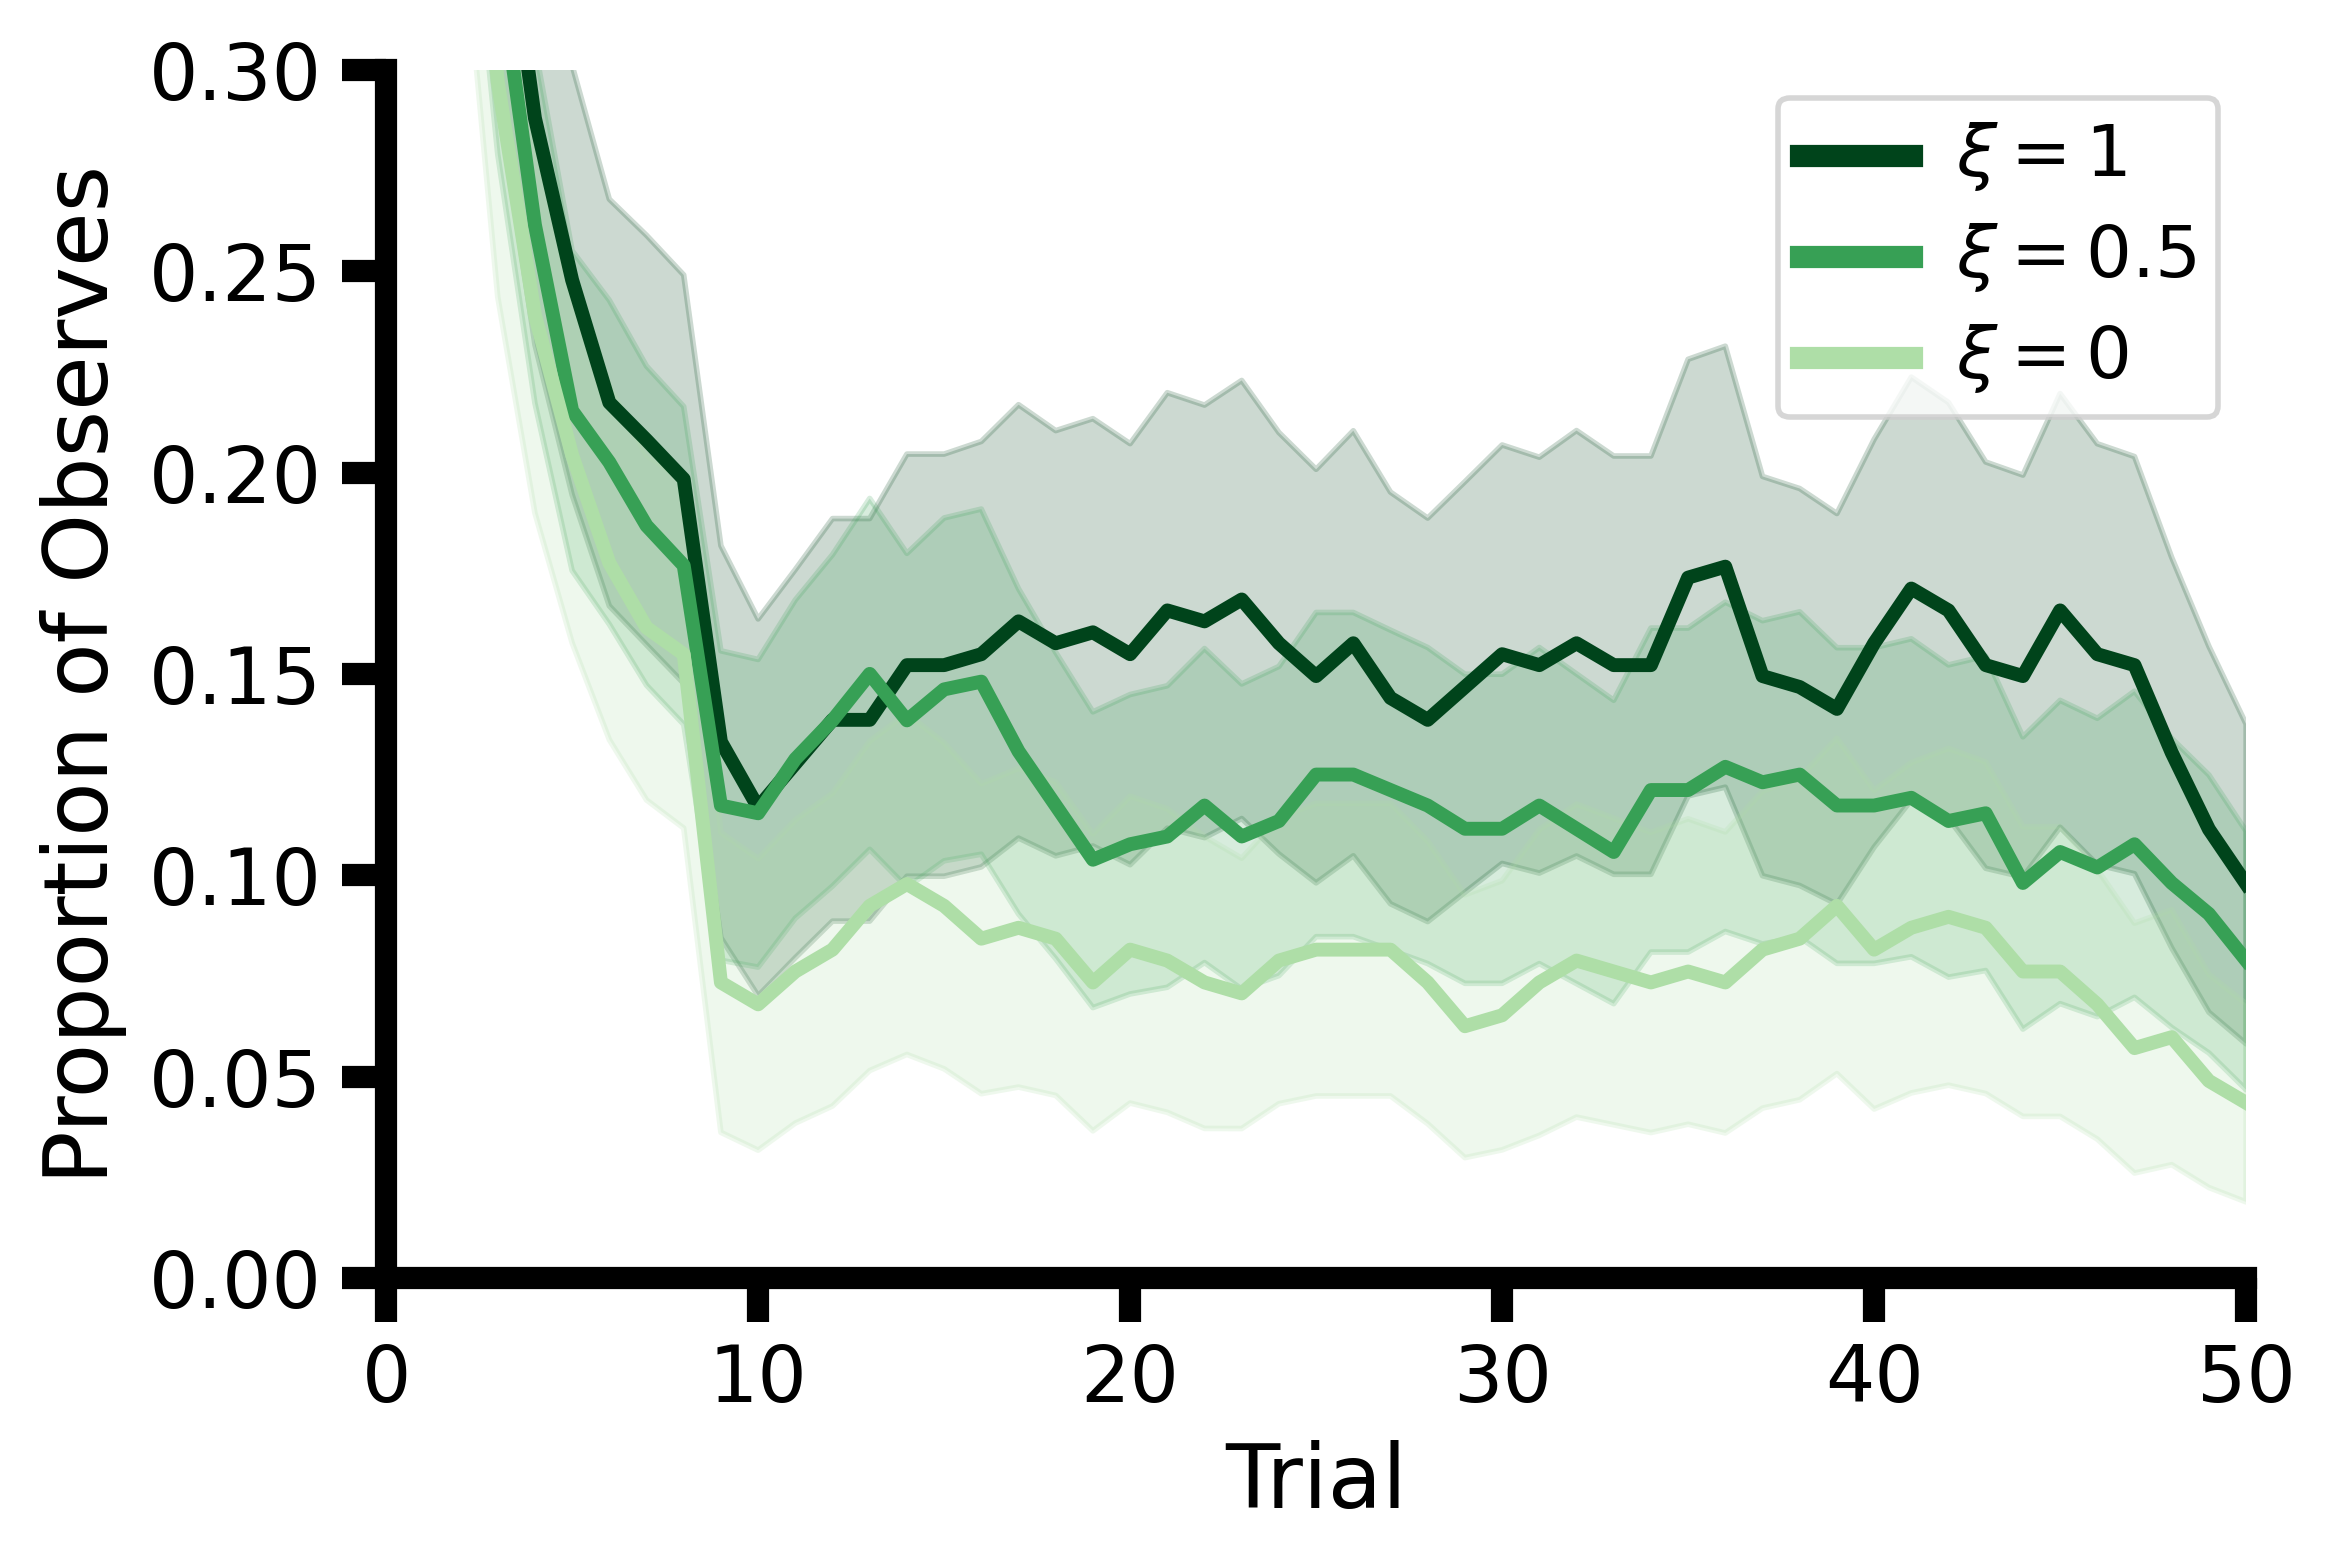

In [5]:
mean_peek_probs = np.array([observation.mean(axis=0) for observation in observations])
stderr_peek_probs = np.array([observation.std(axis=0)/np.sqrt(observation.shape[0]) for observation in observations])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_peek_probs = pd.DataFrame(mean_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_peek_probs = pd.DataFrame(stderr_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = np.arange(1, mean_peek_probs.shape[1]+1)

for i in range(len(mean_peek_probs)):
    # ax.plot(steps, mean_peek_probs[i], label=1-taus[i], color='C%d' %i)
    #ax.plot(steps, mean_peek_probs[i], label=effs_to_plot[i], color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)))
    ax.plot(steps, mean_peek_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)))
    ax.fill_between(steps, mean_peek_probs[i] - stderr_peek_probs[i], mean_peek_probs[i] + stderr_peek_probs[i], color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)), alpha=0.2)

#ax.bar(range(len(policy)))

#ax.legend(title=r"$\xi$")
ax.legend()

ax.set_xlabel("Trial")
ax.set_ylabel("Proportion of Observes")
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if ylim is not None:
    ax.set_ylim(ylim)

ax.set_xlim(0, n_steps)

format_axis(ax)

In [6]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.svg'))

#### Stats

In [7]:
cropped_observations = [observation[:,15:].mean(axis=1) for observation in observations]
plotted_levels = [1, 0.5, 0]

In [8]:
## MEANS AND SEMS
print("Overall N", len(df))

for level, obs in zip(plotted_levels, cropped_observations):
    print("Test Controllability ", level)
    print("Mean ", obs.mean())
    print("StdErr ", obs.std()/np.sqrt(obs.shape[0]))
    print("N", obs.shape[0])

Overall N 111
Test Controllability  1
Mean  0.1440993788819876
StdErr  0.011978290153677799
N 46
Test Controllability  0.5
Mean  0.10681318681318683
StdErr  0.00961576861930955
N 65
Test Controllability  0
Mean  0.0701863354037267
StdErr  0.011204477332150024
N 46


In [9]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_observations)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_observations), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   0.0    0.5   0.0366 0.0451 0.0006 0.0726   True
   0.0    1.0   0.0739    0.0  0.035 0.1129   True
   0.5    1.0   0.0373 0.0405 0.0013 0.0733   True
--------------------------------------------------


In [10]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_observes')
glm.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  n_observes
No. Observations:    999      Method:              REML      
No. Groups:          111      Scale:               5.9663    
Min. group size:     9        Log-Likelihood:      -2459.7416
Max. group size:     9        Converged:           Yes       
Mean group size:     9.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           5.082    0.484 10.506 0.000  4.134  6.031
C(group_C)[T.True] -0.319    0.613 -0.521 0.603 -1.519  0.882
efficacy            2.777    0.239 11.598 0.000  2.308  3.246
Group Var           9.443    0.594                           
=============================================================

"""

### APE-trained neural networks

In [11]:
from settings_anal import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

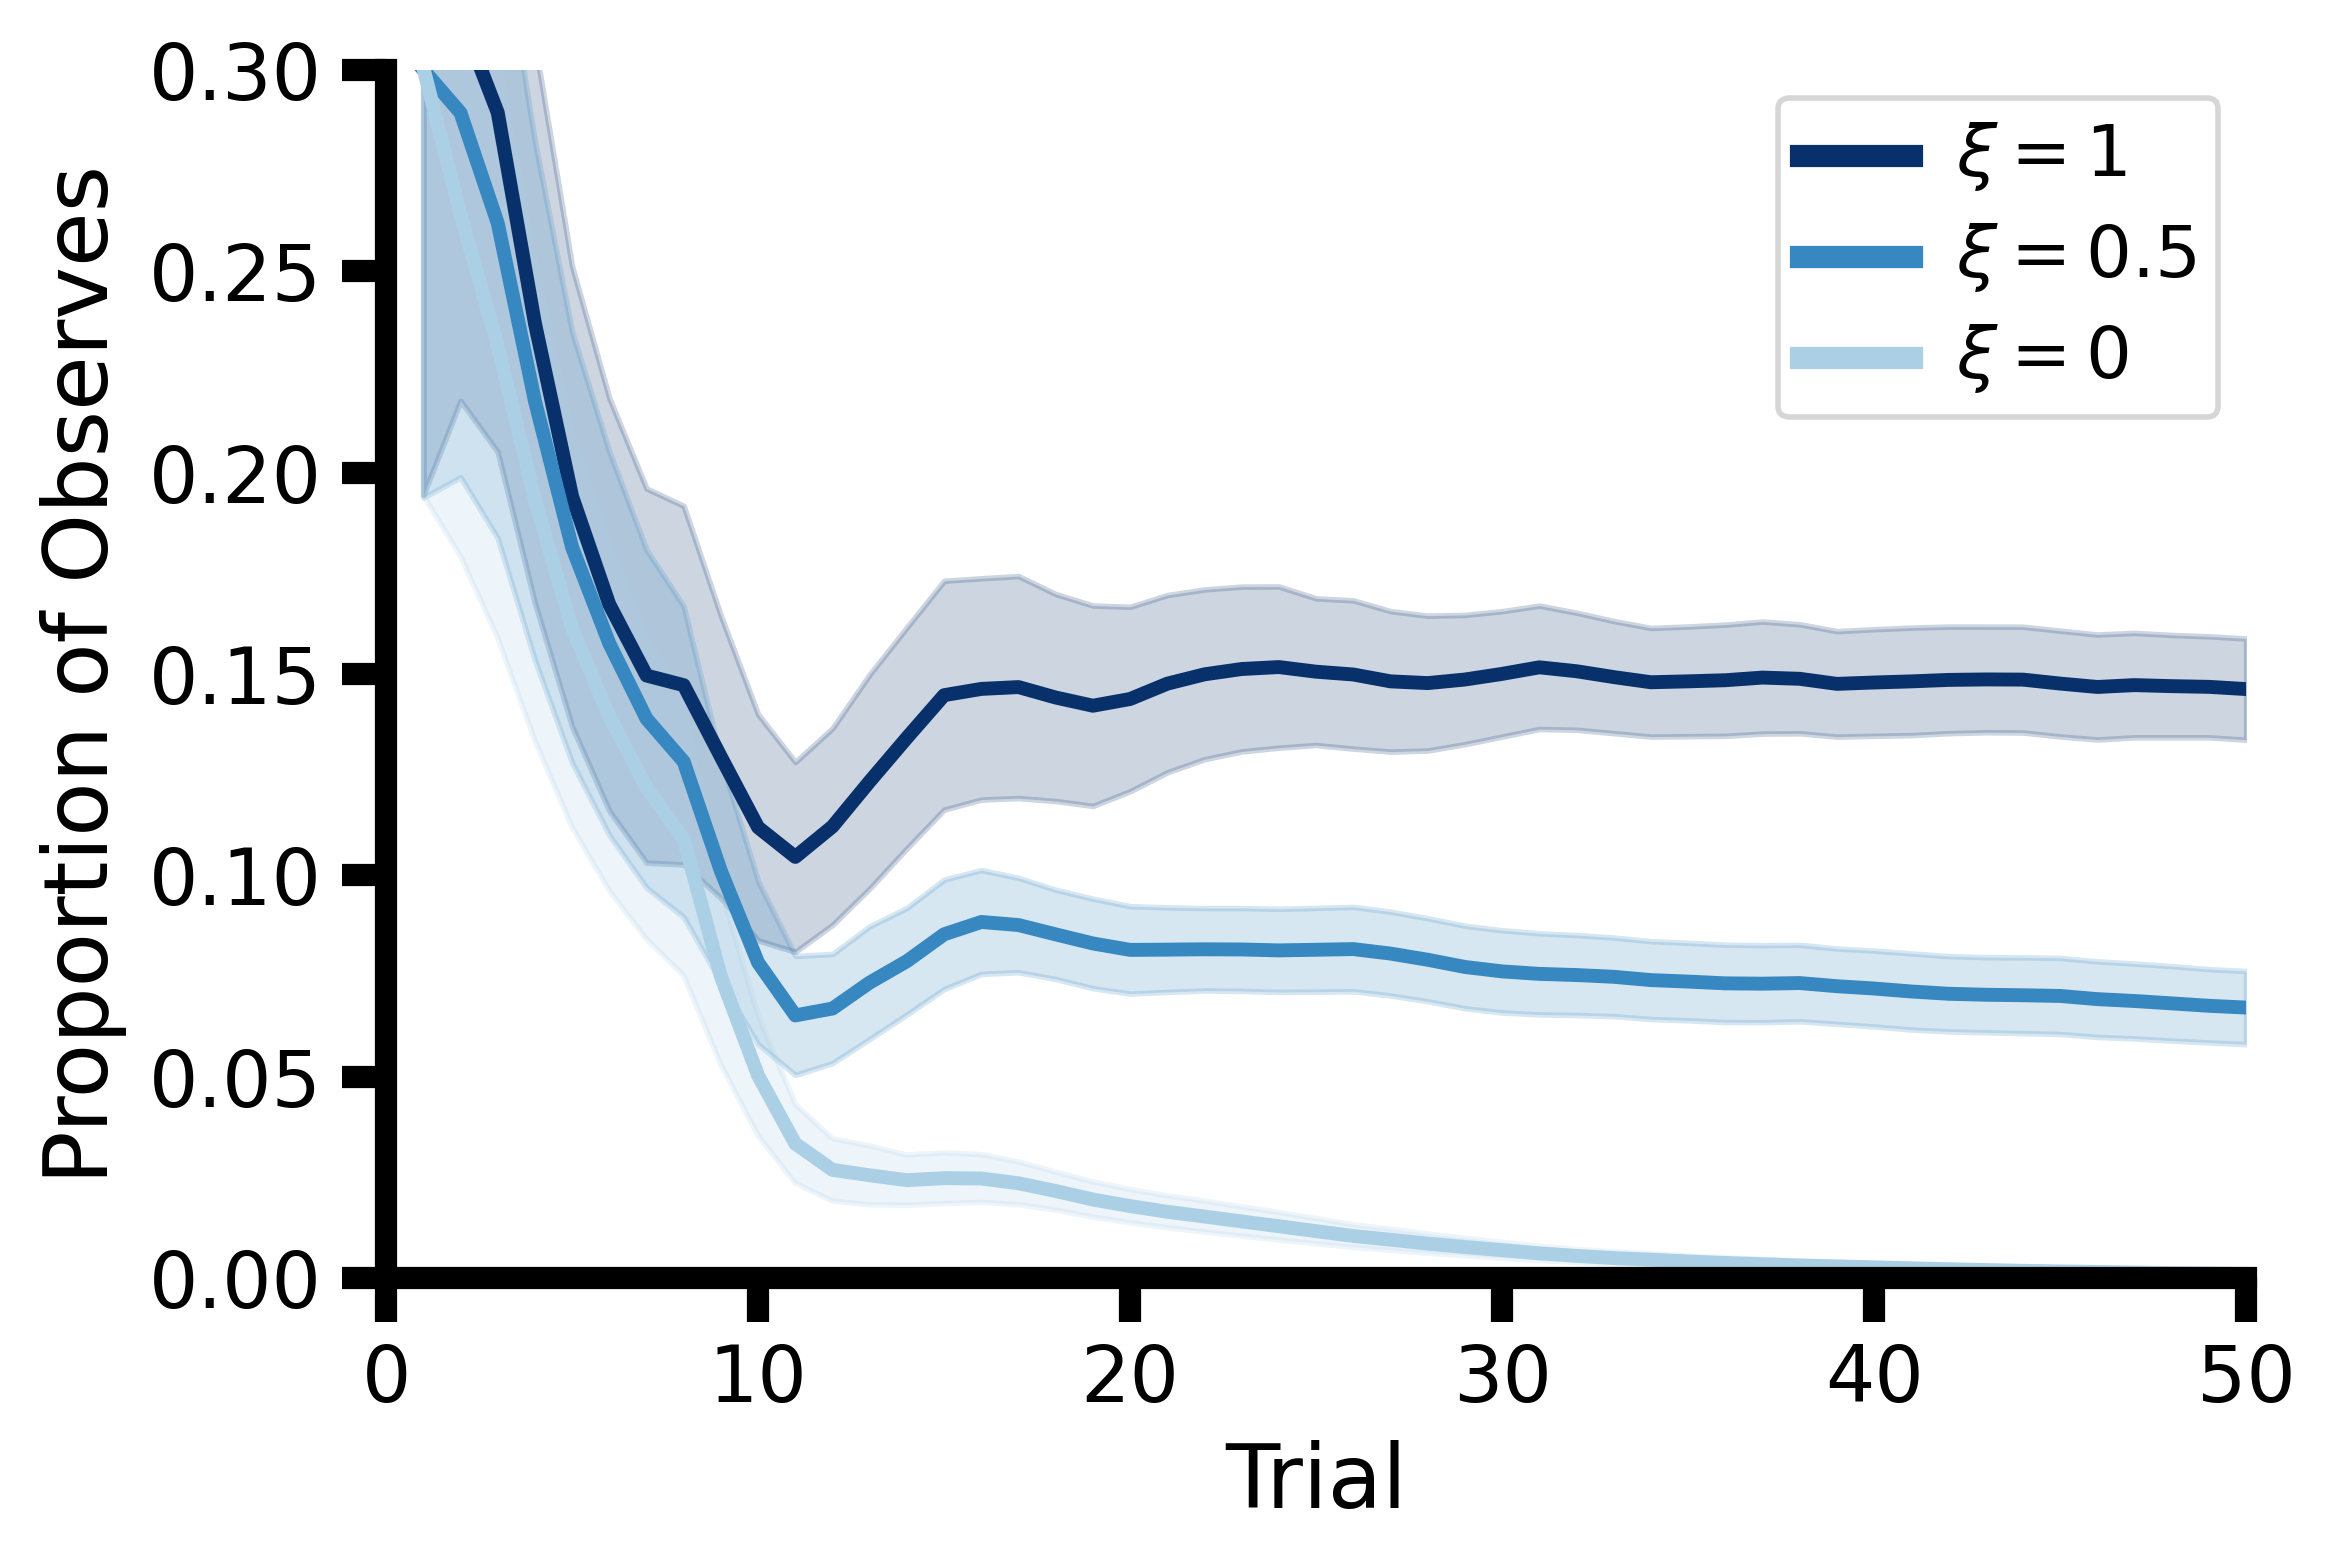

In [12]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Proportion of Observes")

In [13]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_apes.svg'))

### No-APE Networks

In [14]:
from settings_anal import pepe_human_control_models as control_models
from settings_anal import pepe_human_control_traj_timestamp as traj_timestamp
from utils_project import load_modelrun_files

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

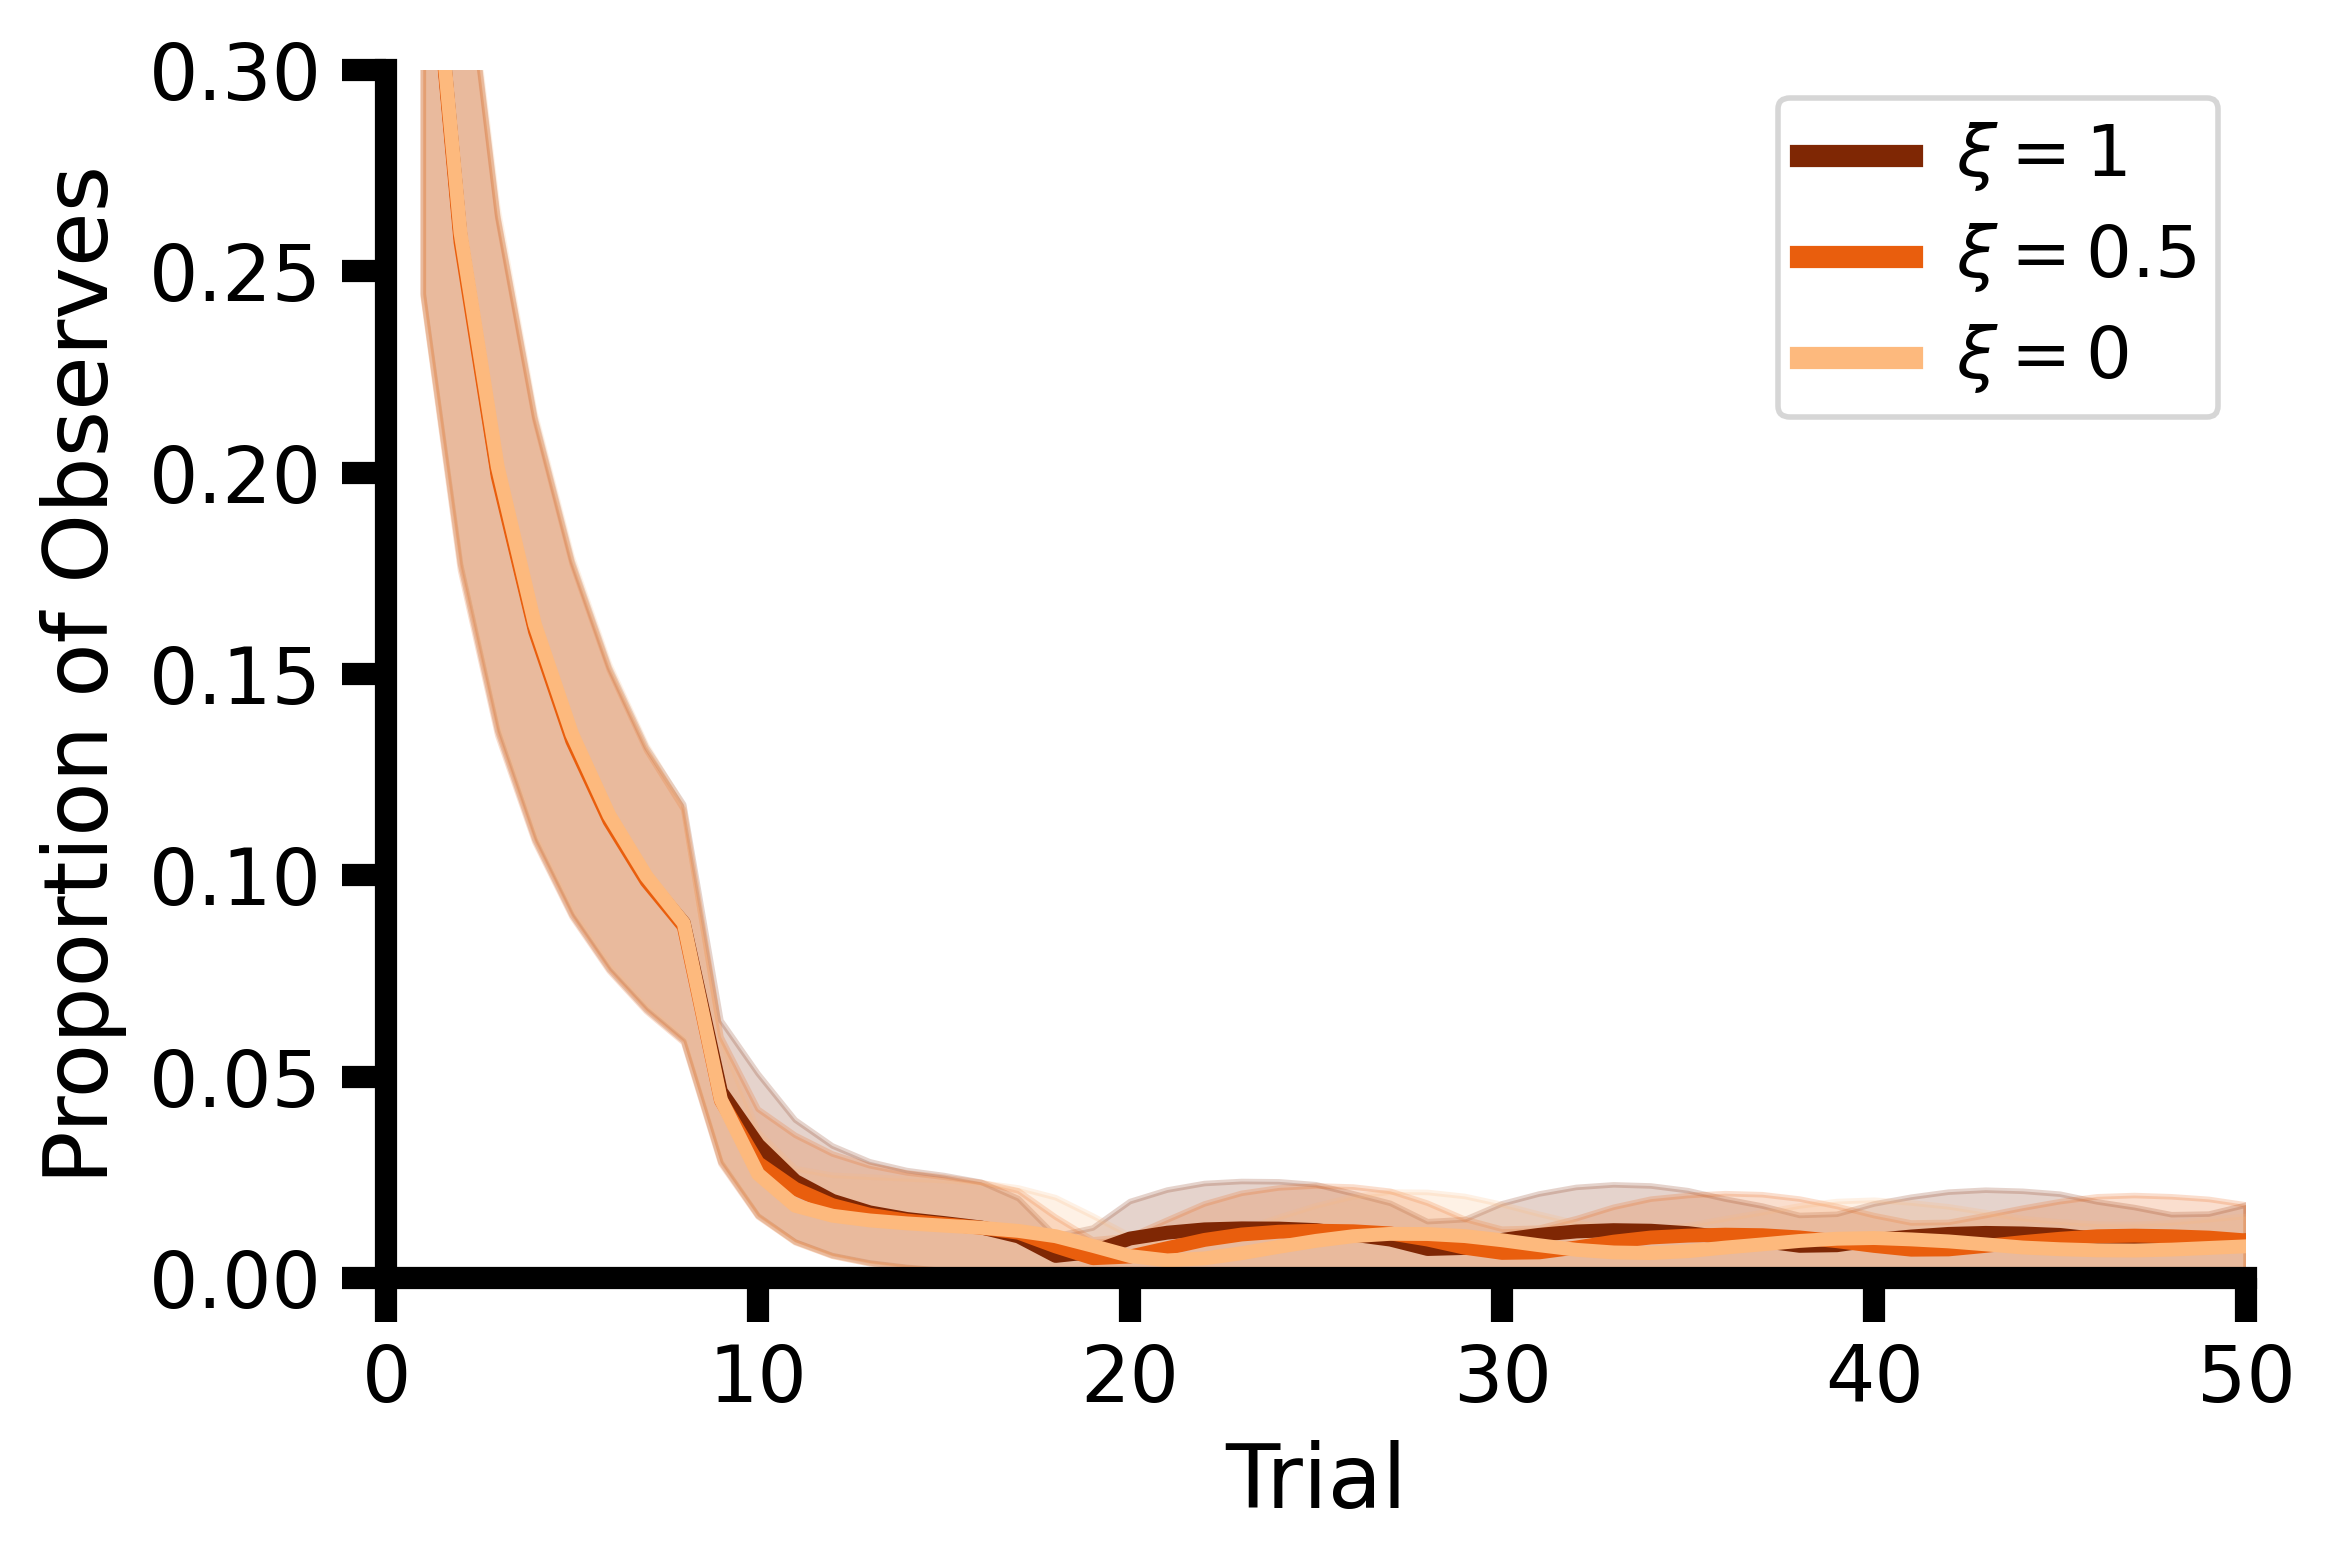

In [15]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Proportion of Observes")

In [16]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.svg'))

## Panel B: Single-Episode Rewards
### General Options

In [17]:
ylim = (0.1, 0.9)
smoothing_window = 8

### Humans

In [18]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [19]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start, group = df['group'])
correct_takes = transitions_test
correct_takes = [correct_takes[0][:,3], correct_takes[1][:,2], correct_takes[0][:,0]] ## plotting highest efficacy first

## convert observations to np.nans
for correct_take in correct_takes:
    correct_take[correct_take == 0.5] = np.nan

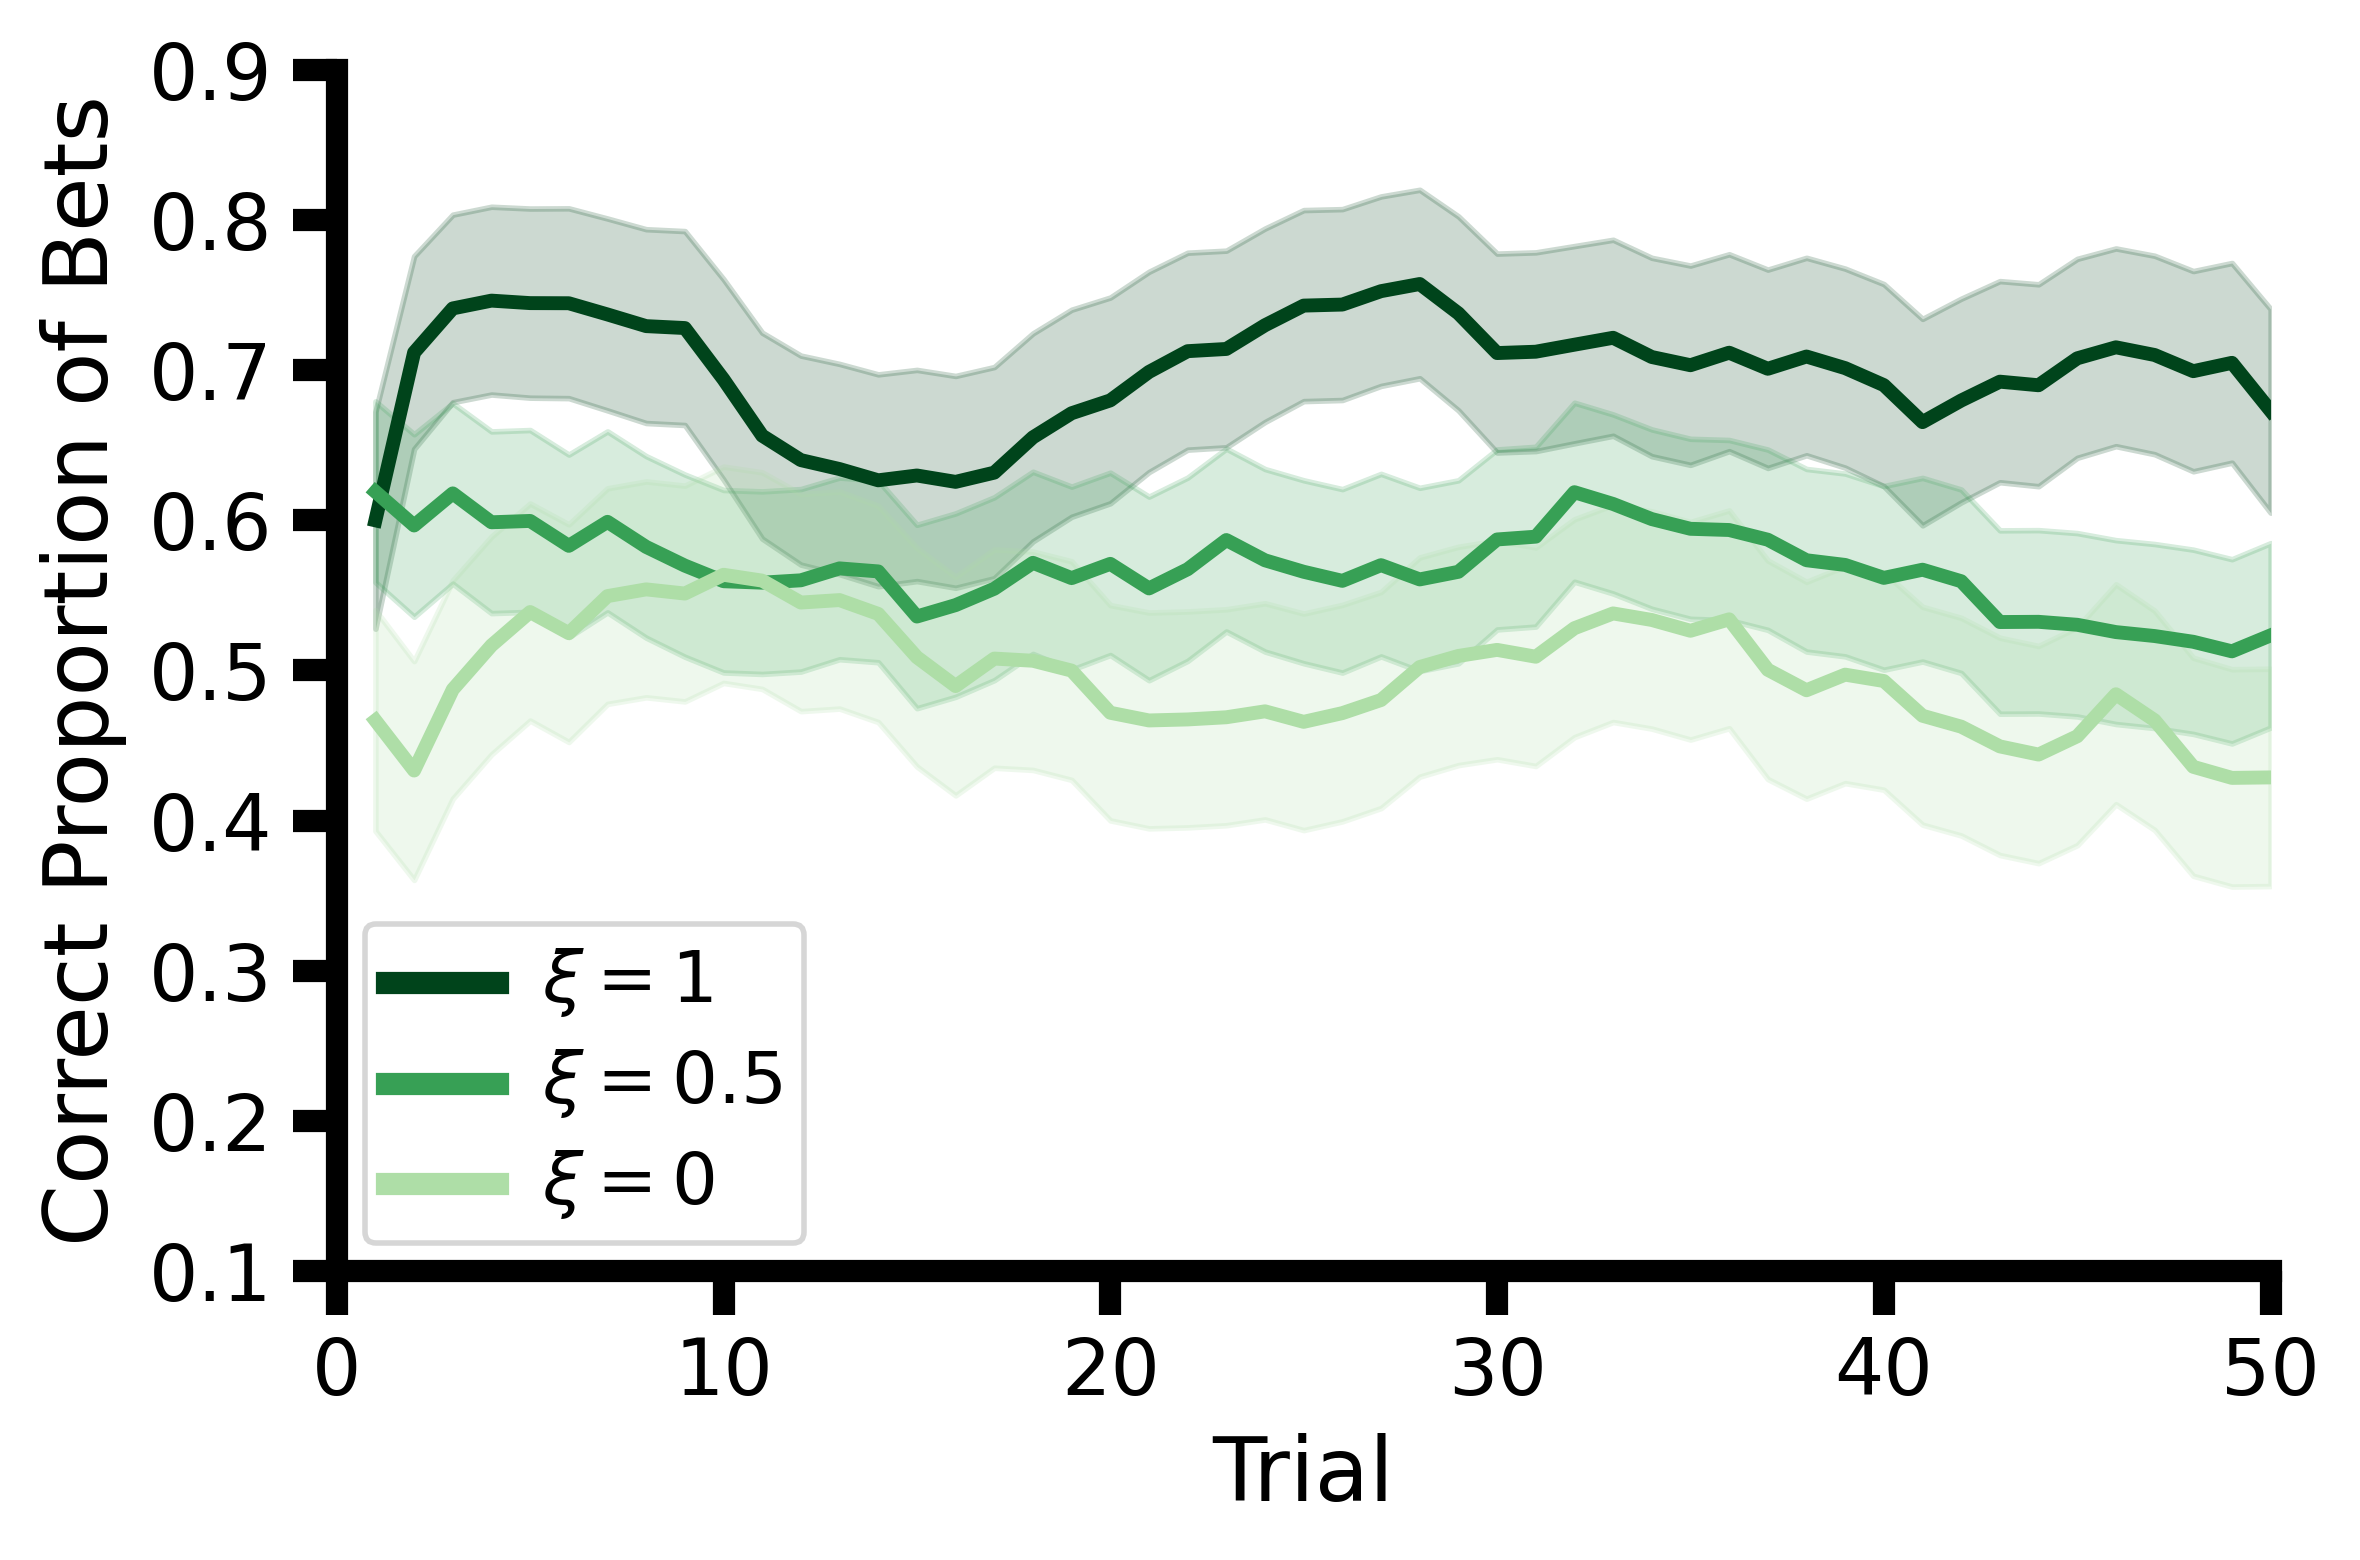

In [23]:
mean_probs = np.array([np.nanmean(correct_take, axis=0) for correct_take in correct_takes])
stderr_probs = np.array([np.nanstd(correct_take, axis=0)/np.sqrt(correct_take.shape[0]) for correct_take in correct_takes])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_probs = pd.DataFrame(mean_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_probs = pd.DataFrame(stderr_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = np.arange(1, mean_probs.shape[1]+1)

for i in range(len(mean_probs)):
    #print(mean_probs[i])
    # ax.plot(steps, mean_peek_probs[i], label=1-taus[i], color='C%d' %i)
    #ax.plot(steps, mean_probs[i], label=effs_to_plot[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.plot(steps, mean_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.fill_between(steps, mean_probs[i] - stderr_probs[i], mean_probs[i] + stderr_probs[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)), alpha=0.2)

#ax.bar(range(len(policy)))

#ax.legend(title="Efficacy")
ax.legend()

#ax.set_xlabel("Steps")
ax.set_xlabel("Trial")
ax.set_ylabel("Correct Proportion of Bets")
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if ylim is not None:
    ax.set_ylim(ylim)

ax.set_xlim(0, n_steps)

format_axis(ax)

plt.tight_layout()


In [24]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.svg'))

#### Stats

In [25]:
cropped_takes = [np.nanmean(take[:,15:], axis=1) for take in correct_takes]
plotted_levels = [1, 0.5, 0]

In [26]:
## MEANS AND SEMS
for level, takes in zip(plotted_levels, cropped_takes):
    print("Test Controllability ", level)
    print("Mean ", np.nanmean(takes))
    print("StdErr ", np.nanstd(takes)/np.sqrt(len(takes)))
    print("N" , len(takes))

Test Controllability  1
Mean  0.7078379106638373
StdErr  0.027844941618651885
N 46
Test Controllability  0.5
Mean  0.5664165619858598
StdErr  0.015941210054804617
N 65
Test Controllability  0
Mean  0.47848061386263196
StdErr  0.012400078710872137
N 46


In [27]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_takes)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_takes), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    0.5   0.0879 0.004 0.0239  0.152   True
   0.0    1.0   0.2294   0.0   0.16 0.2987   True
   0.5    1.0   0.1414   0.0 0.0774 0.2055   True
-------------------------------------------------


In [28]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_observes')
glm.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  n_observes
No. Observations:    999      Method:              REML      
No. Groups:          111      Scale:               5.9663    
Min. group size:     9        Log-Likelihood:      -2459.7416
Max. group size:     9        Converged:           Yes       
Mean group size:     9.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           5.082    0.484 10.506 0.000  4.134  6.031
C(group_C)[T.True] -0.319    0.613 -0.521 0.603 -1.519  0.882
efficacy            2.777    0.239 11.598 0.000  2.308  3.246
Group Var           9.443    0.594                           
=============================================================

"""

### APE-trained Neural Networks

In [29]:
from settings_anal import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

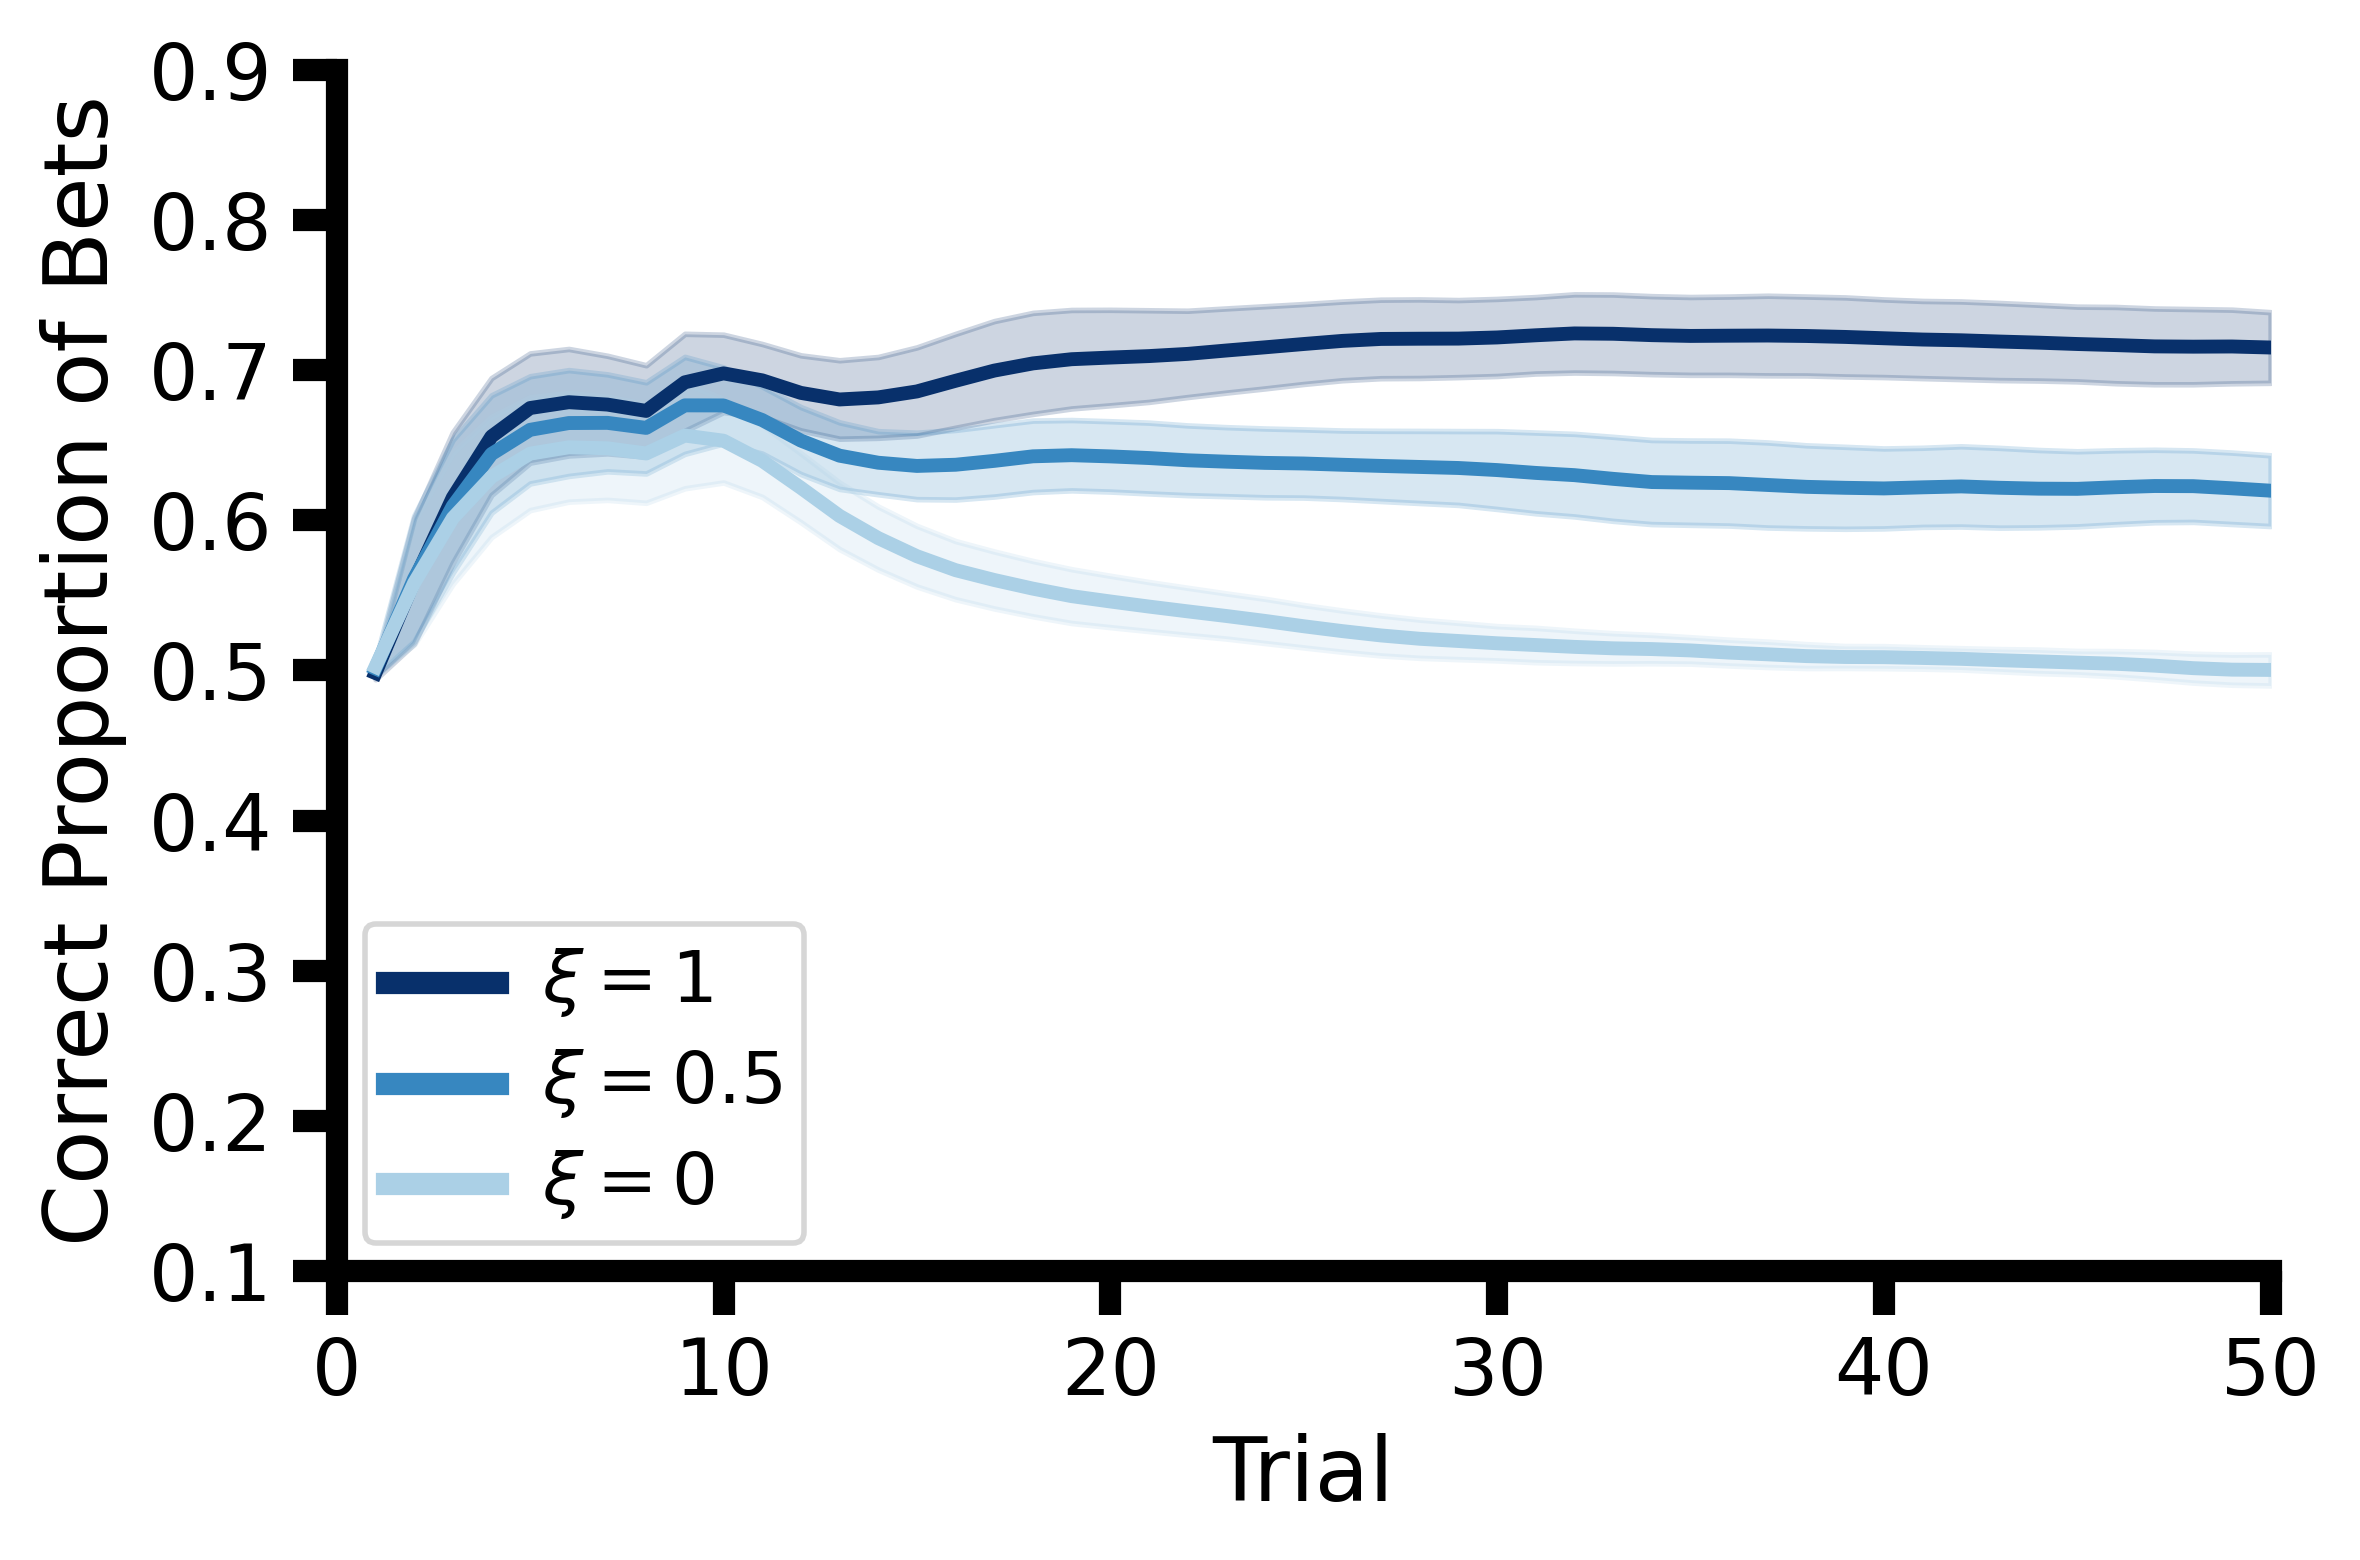

In [30]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, trajss_ps_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Correct Proportion of Bets")

In [31]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.svg'))

### No-APE Networks

In [32]:
from settings_anal import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

trajss_ps_taus_control = np.array(trajss_ps_taus_control)
trajss_ps_taus_control = trajss_ps_taus_control[:, ::4]

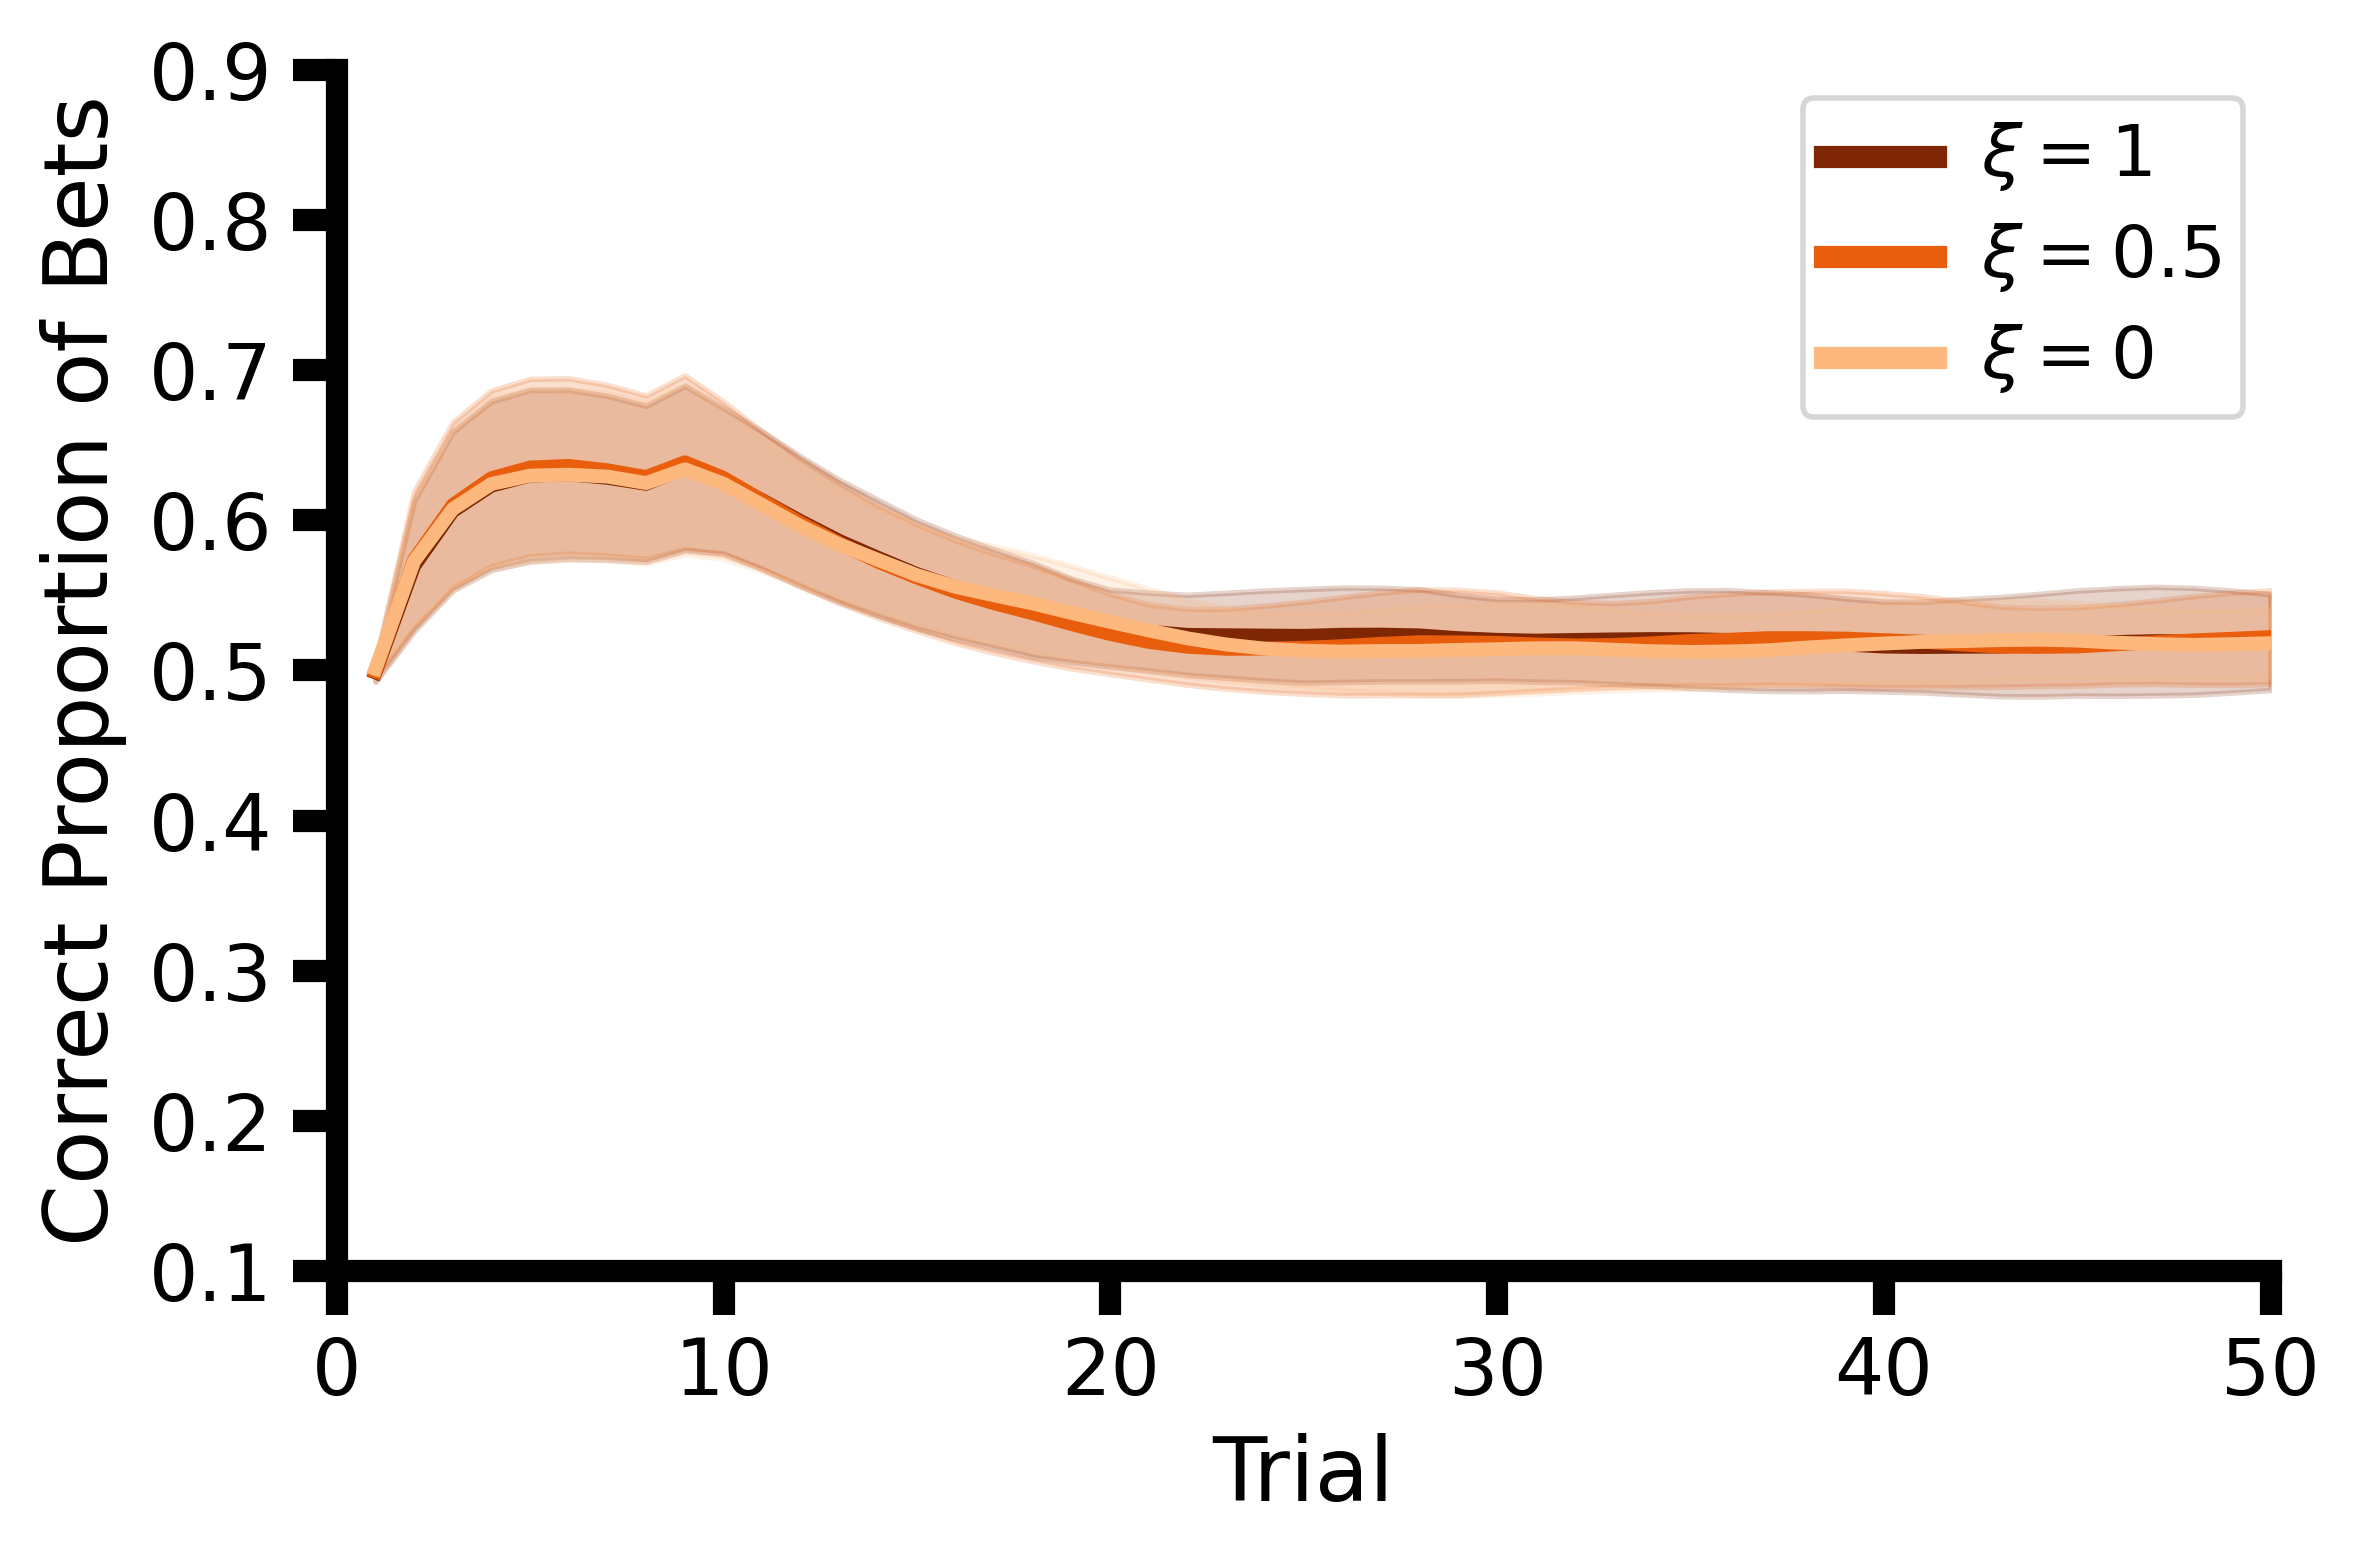

In [33]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_control, trajss_ps_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Correct Proportion of Bets")

In [34]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noape.svg'))

## Panel C: Across-Efficacy Observations
### General Options

In [35]:
ylim = (-1.25,25.5)

### Humans

In [36]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [37]:
n_trainA, n_testA = sort_train_test(df[~df['group']]['n_observes'], df[~df['group']]['effs'], test_start[0])
n_trainB, n_testB = sort_train_test(df[df['group']]['n_observes'], df[df['group']]['effs'], test_start[1])


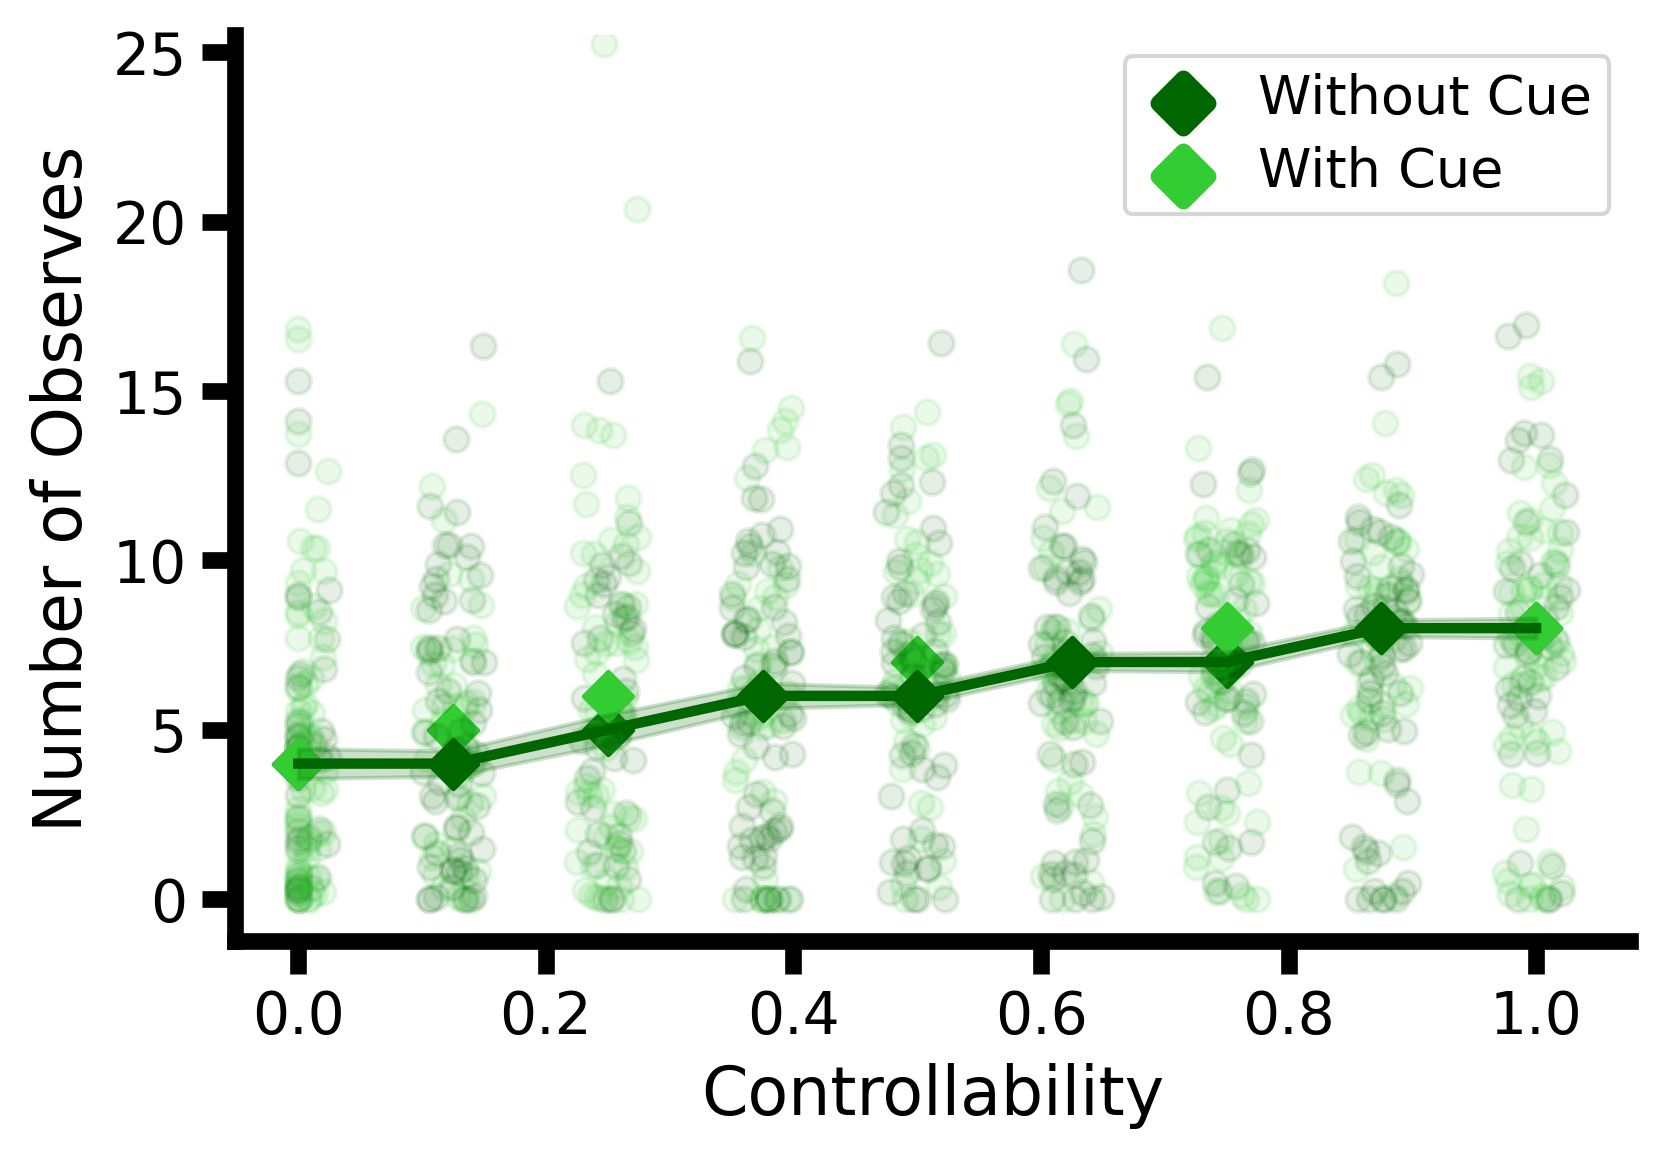

In [38]:
from human_plot_traj_analyses import plot_line_scatter_group
    
fig = plot_line_scatter_group((n_testA, n_testB), effs_test, (n_trainA, n_trainB), effs_train, ylabel='Number of Observes', xjitter=0.025, yjitter=1, median_over_mean=True, ylim=ylim, xlabel="Controllability")

In [36]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.svg'))

### APE-trained neural networks

In [ ]:
from settings_anal import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

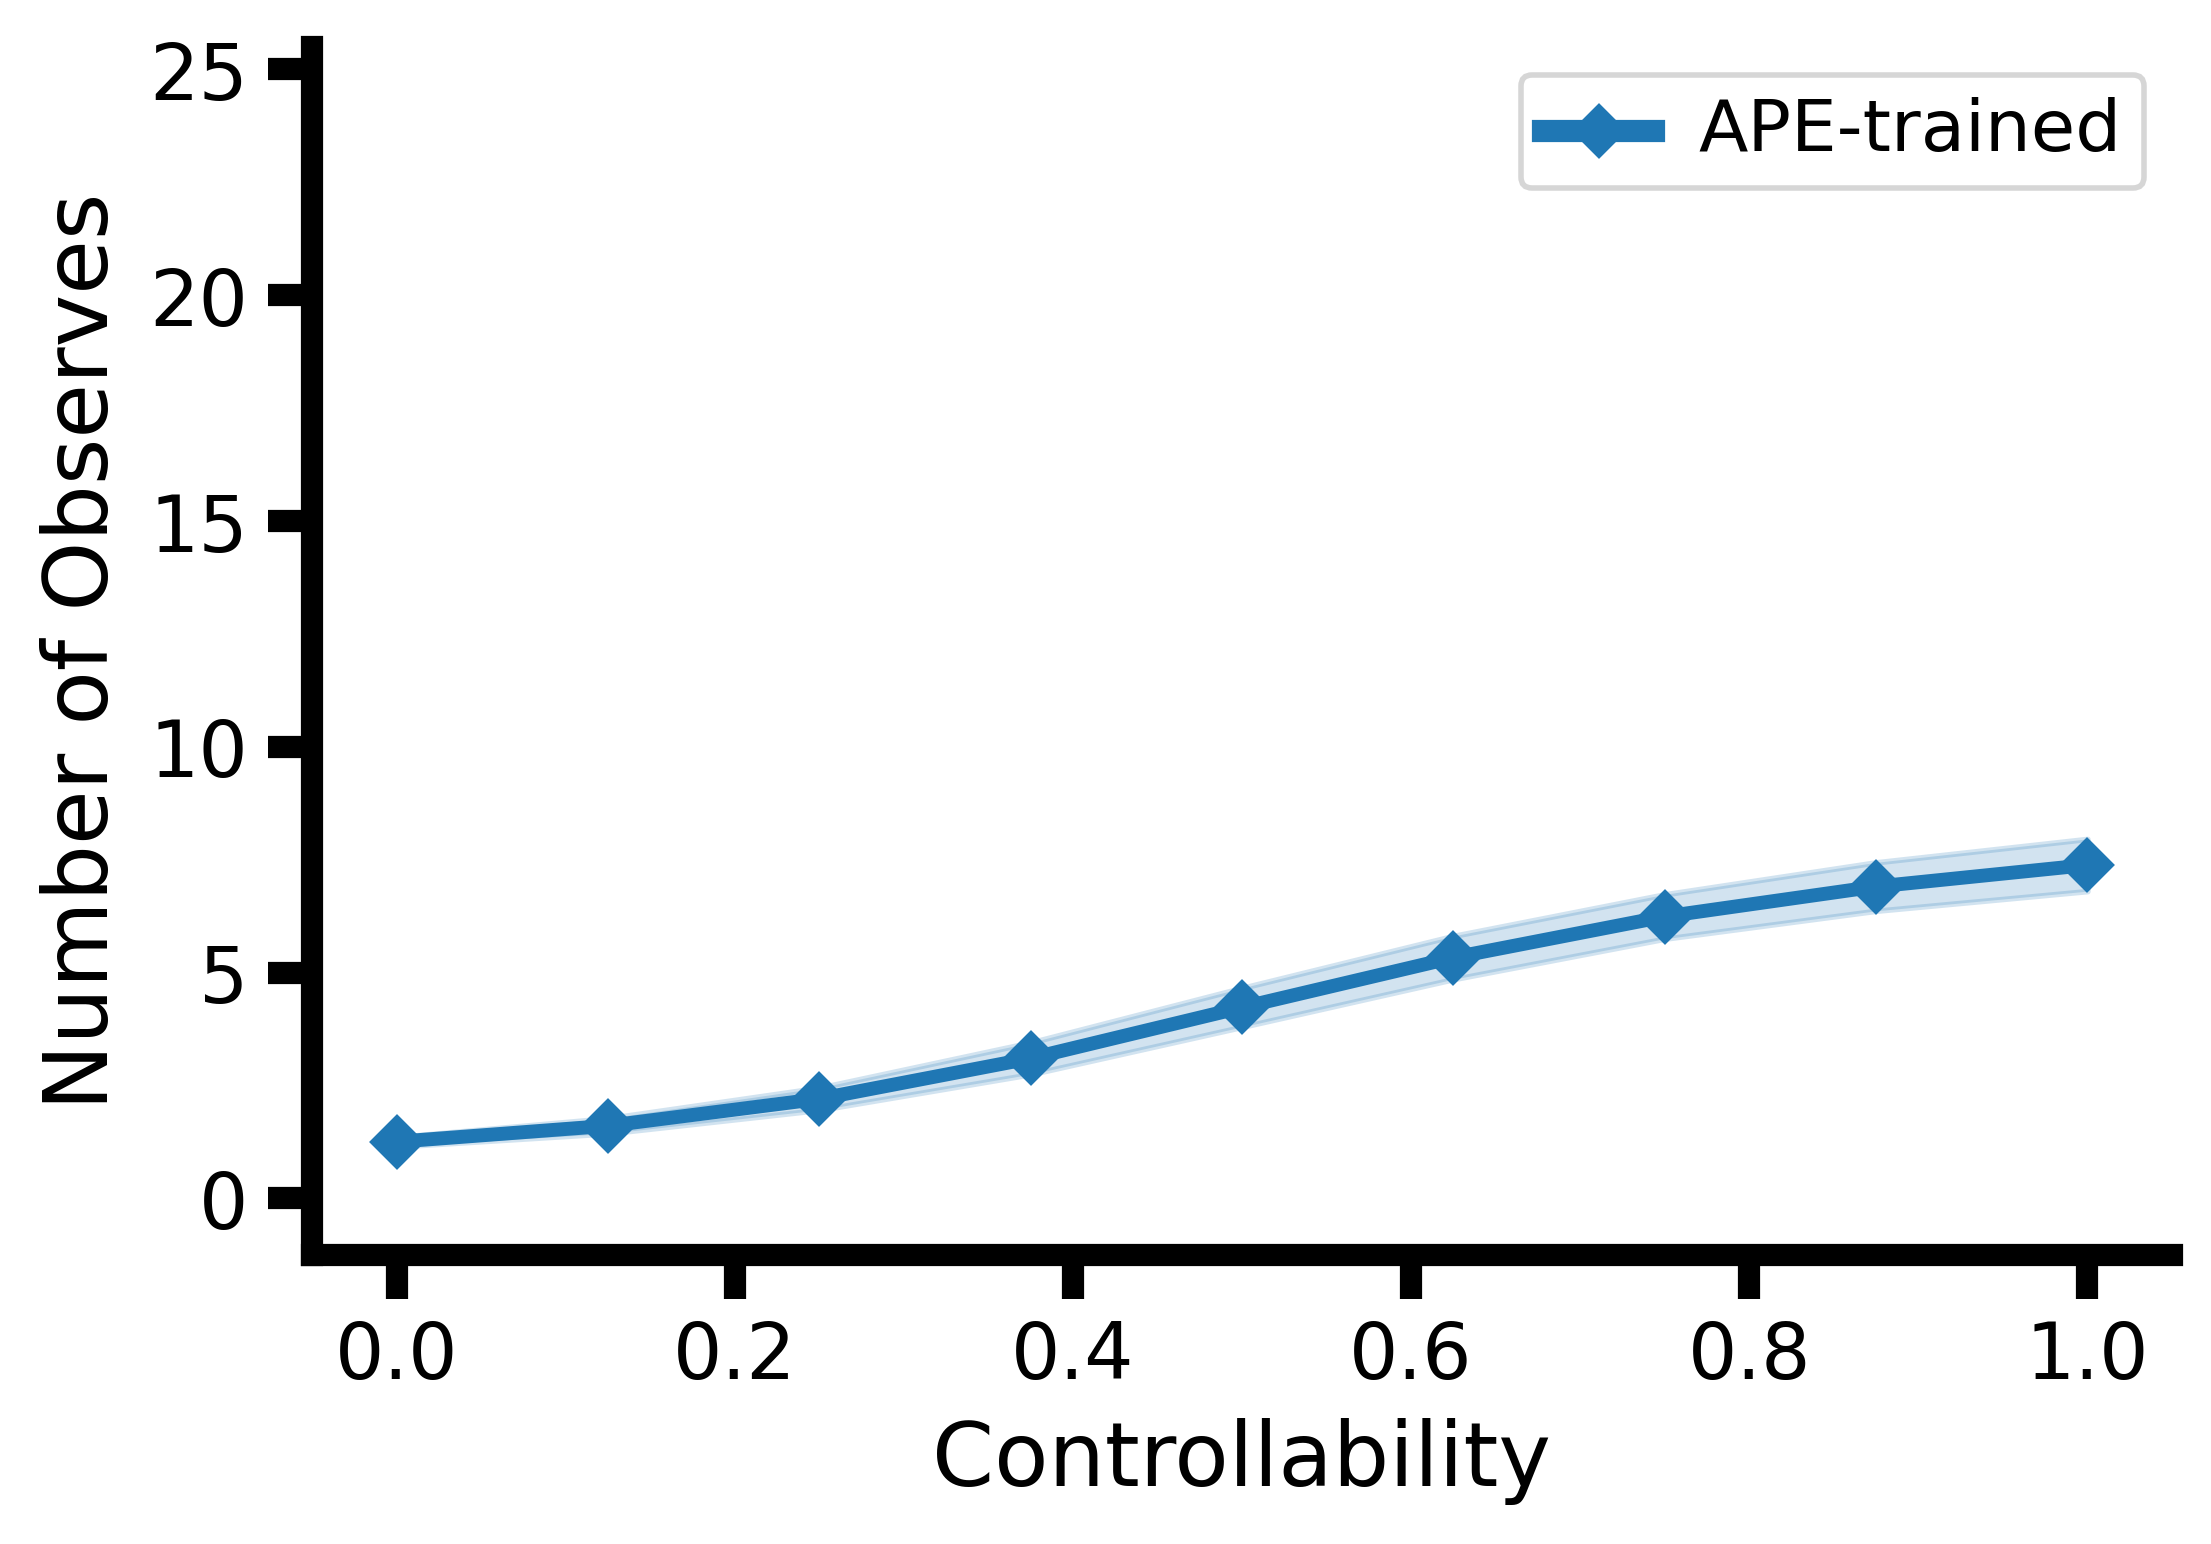

In [ ]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(test_taus, list(reversed(counterss_peeks_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [ ]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.svg'))

### No-APE Networks

In [ ]:
from settings_anal import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

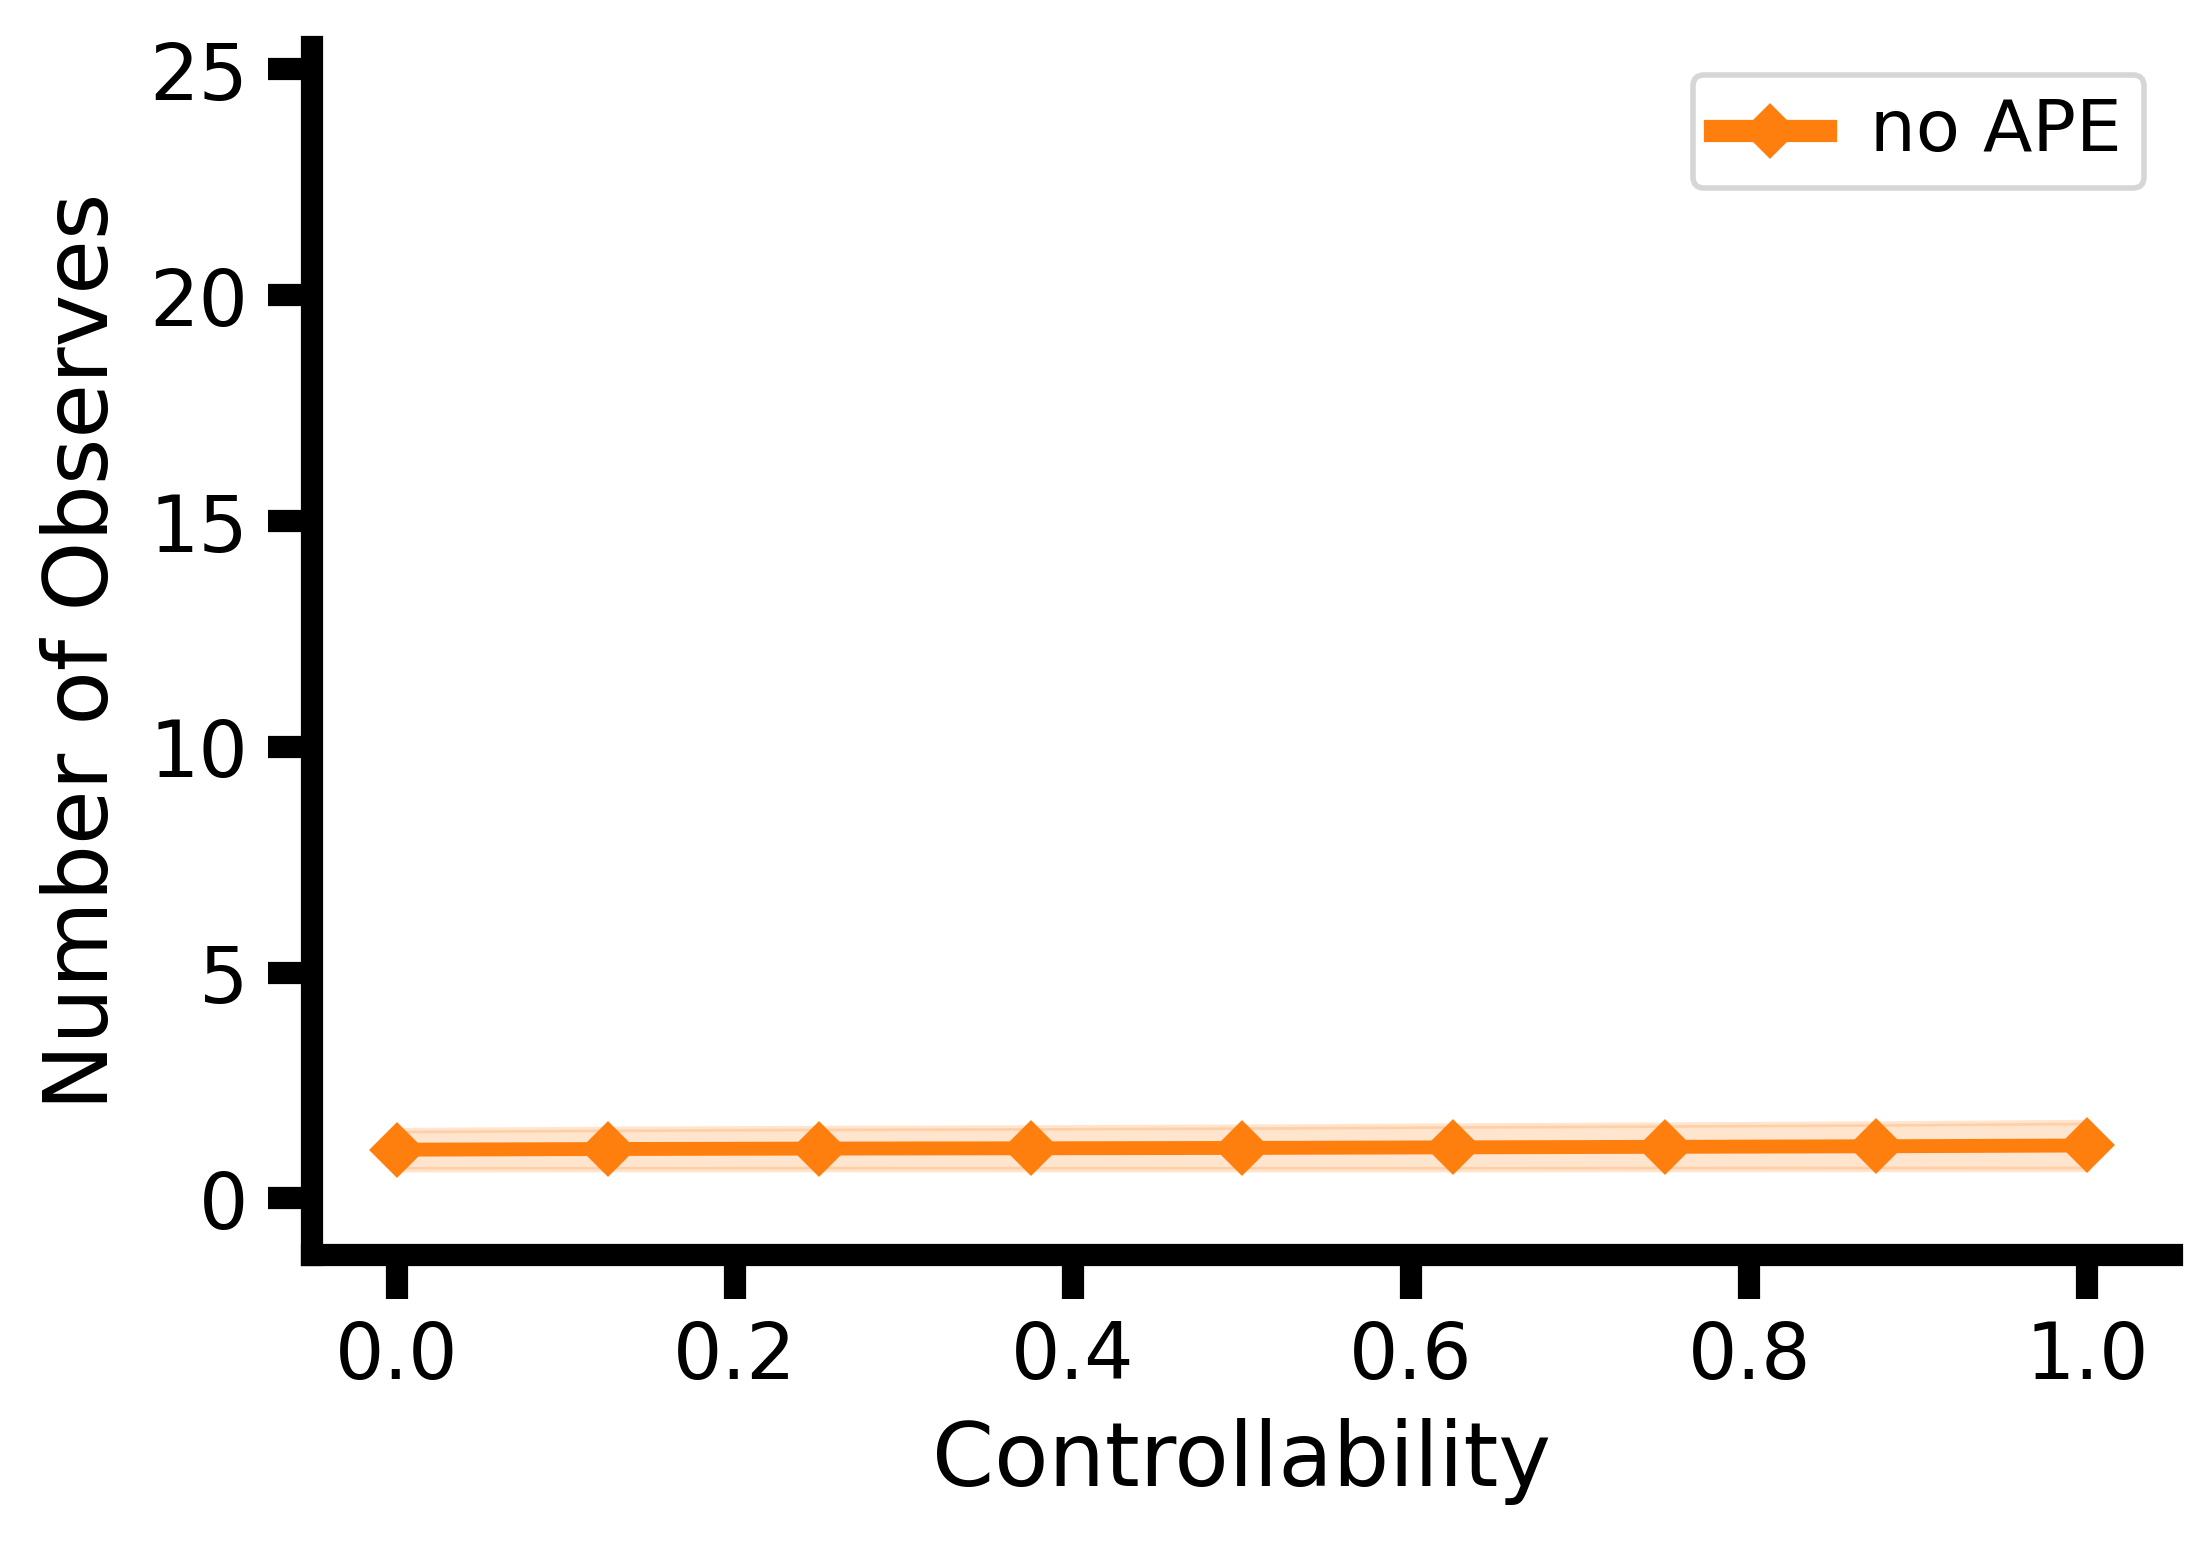

In [ ]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(counterss_peeks_taus_control)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [ ]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.svg'))

## Panel D: Across-Episode Rewards
### General Options

In [ ]:
ylim= (-1, 49)

### Humans

In [ ]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [ ]:
n_trainA, n_testA = sort_train_test(df[~df['group']]['rewards_tallies'], df[~df['group']]['effs'], test_start[0])
n_trainB, n_testB = sort_train_test(df[df['group']]['rewards_tallies'], df[df['group']]['effs'], test_start[1])

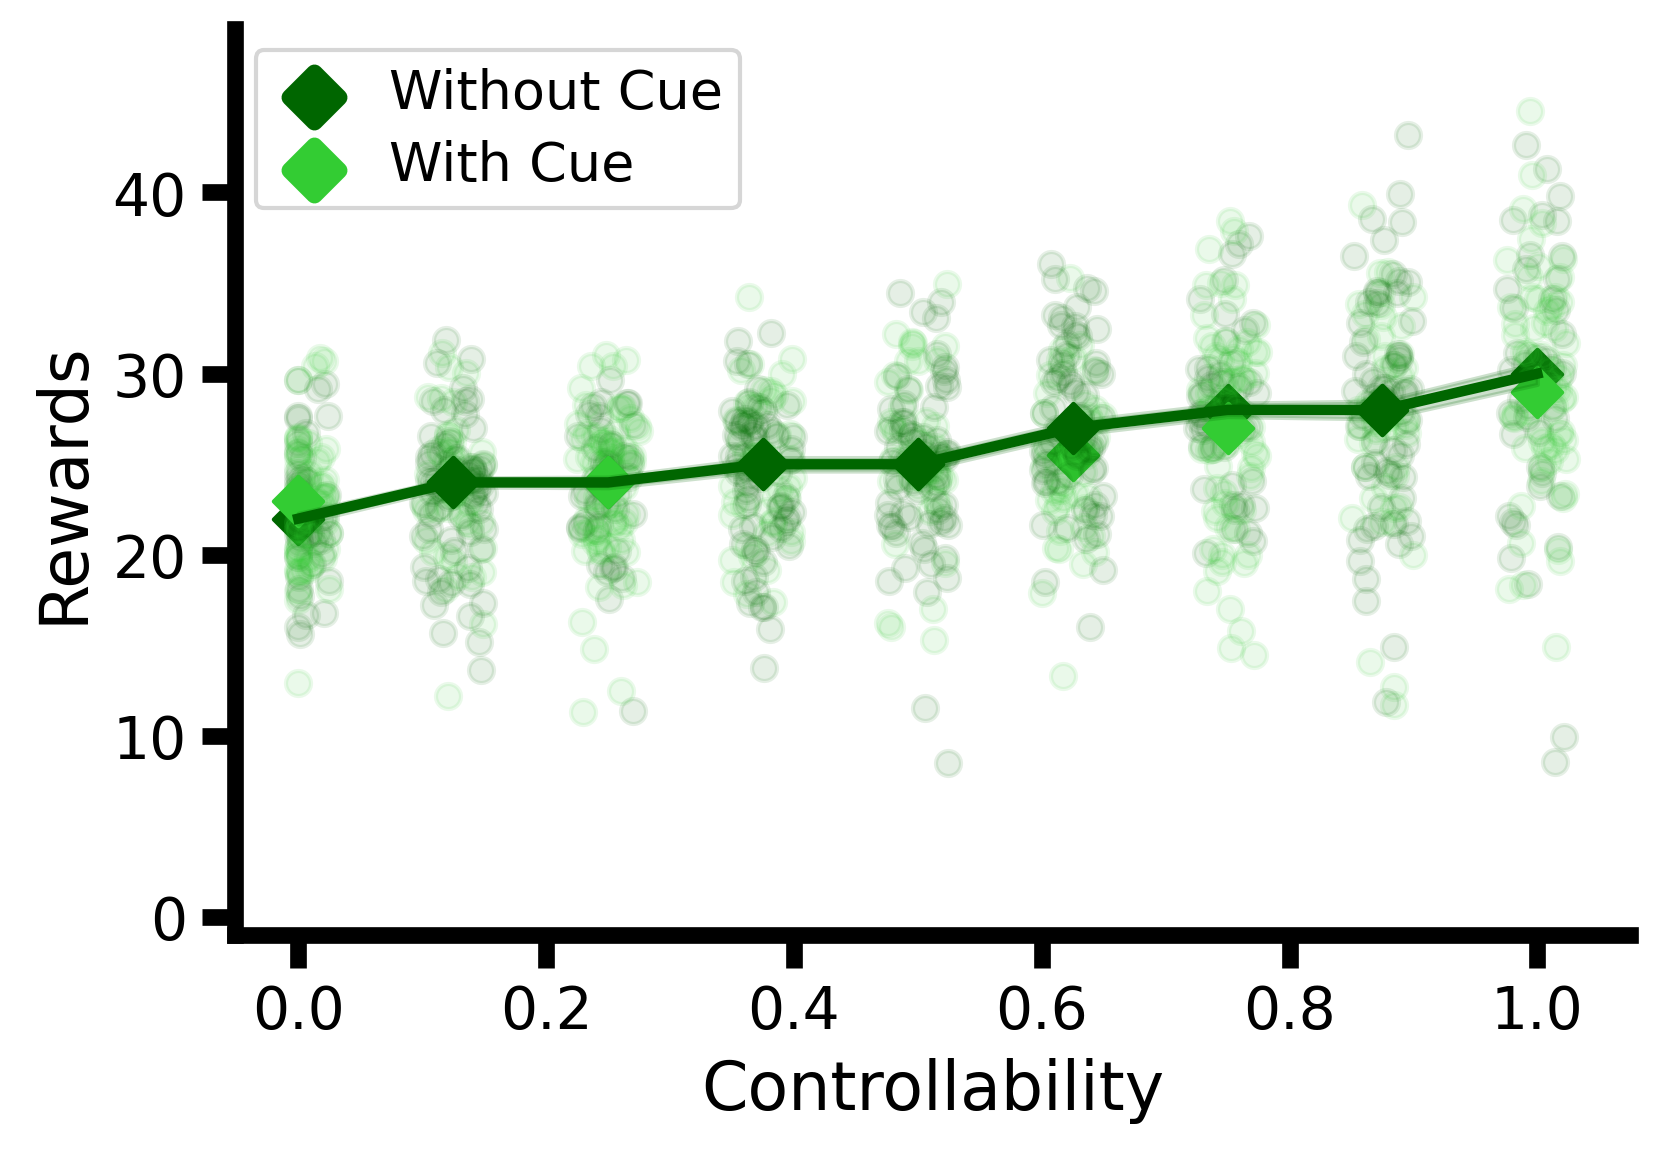

In [ ]:
from human_plot_traj_analyses import plot_line_scatter_group

fig = plot_line_scatter_group((n_testA, n_testB), effs_test, (n_trainA, n_trainB), effs_train, ylabel='Rewards', ylim=ylim, xjitter=0.025, yjitter=1, median_over_mean=True,)

In [ ]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.svg'))

#### Stats

In [ ]:
selected_rewards_tallies = [n_testA[:,-1], n_testB[:,2], n_testA[:,0]]

In [ ]:
## MEANS AND SEMS
for level, rewards in zip(plotted_levels, selected_rewards_tallies):
    print("Test Controllability ", level)
    print("Mean ", rewards.mean())
    print("StdErr ", rewards.std()/np.sqrt(rewards.shape[0]))
    print("N", rewards.shape[0])

Test Controllability  1
Mean  29.369565217391305
StdErr  1.0642669653730146
N 46
Test Controllability  0.5
Mean  24.661538461538463
StdErr  0.585940572173709
N 65
Test Controllability  0
Mean  22.47826086956522
StdErr  0.5187770358133812
N 46


In [ ]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, selected_rewards_tallies)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(selected_rewards_tallies), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    0.5   2.1833 0.0899 -0.2587 4.6252  False
   0.0    1.0   6.8913    0.0  4.2486  9.534   True
   0.5    1.0    4.708    0.0  2.2661   7.15   True
---------------------------------------------------


In [10]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'rewards_tallies')
glm.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: rewards_tallies
No. Observations: 999     Method:             REML           
No. Groups:       111     Scale:              19.9434        
Min. group size:  9       Log-Likelihood:     -2948.6878     
Max. group size:  9       Converged:          Yes            
Mean group size:  9.0                                        
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          22.341    0.377 59.304 0.000 21.603 23.080
C(group_C)[T.True] -0.024    0.401 -0.061 0.951 -0.810  0.761
efficacy            6.549    0.438 14.960 0.000  5.691  7.407
Group Var           2.109    0.139                           
=============================================================

"""

### APE-trained Neural Networks

In [ ]:
from settings_anal import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

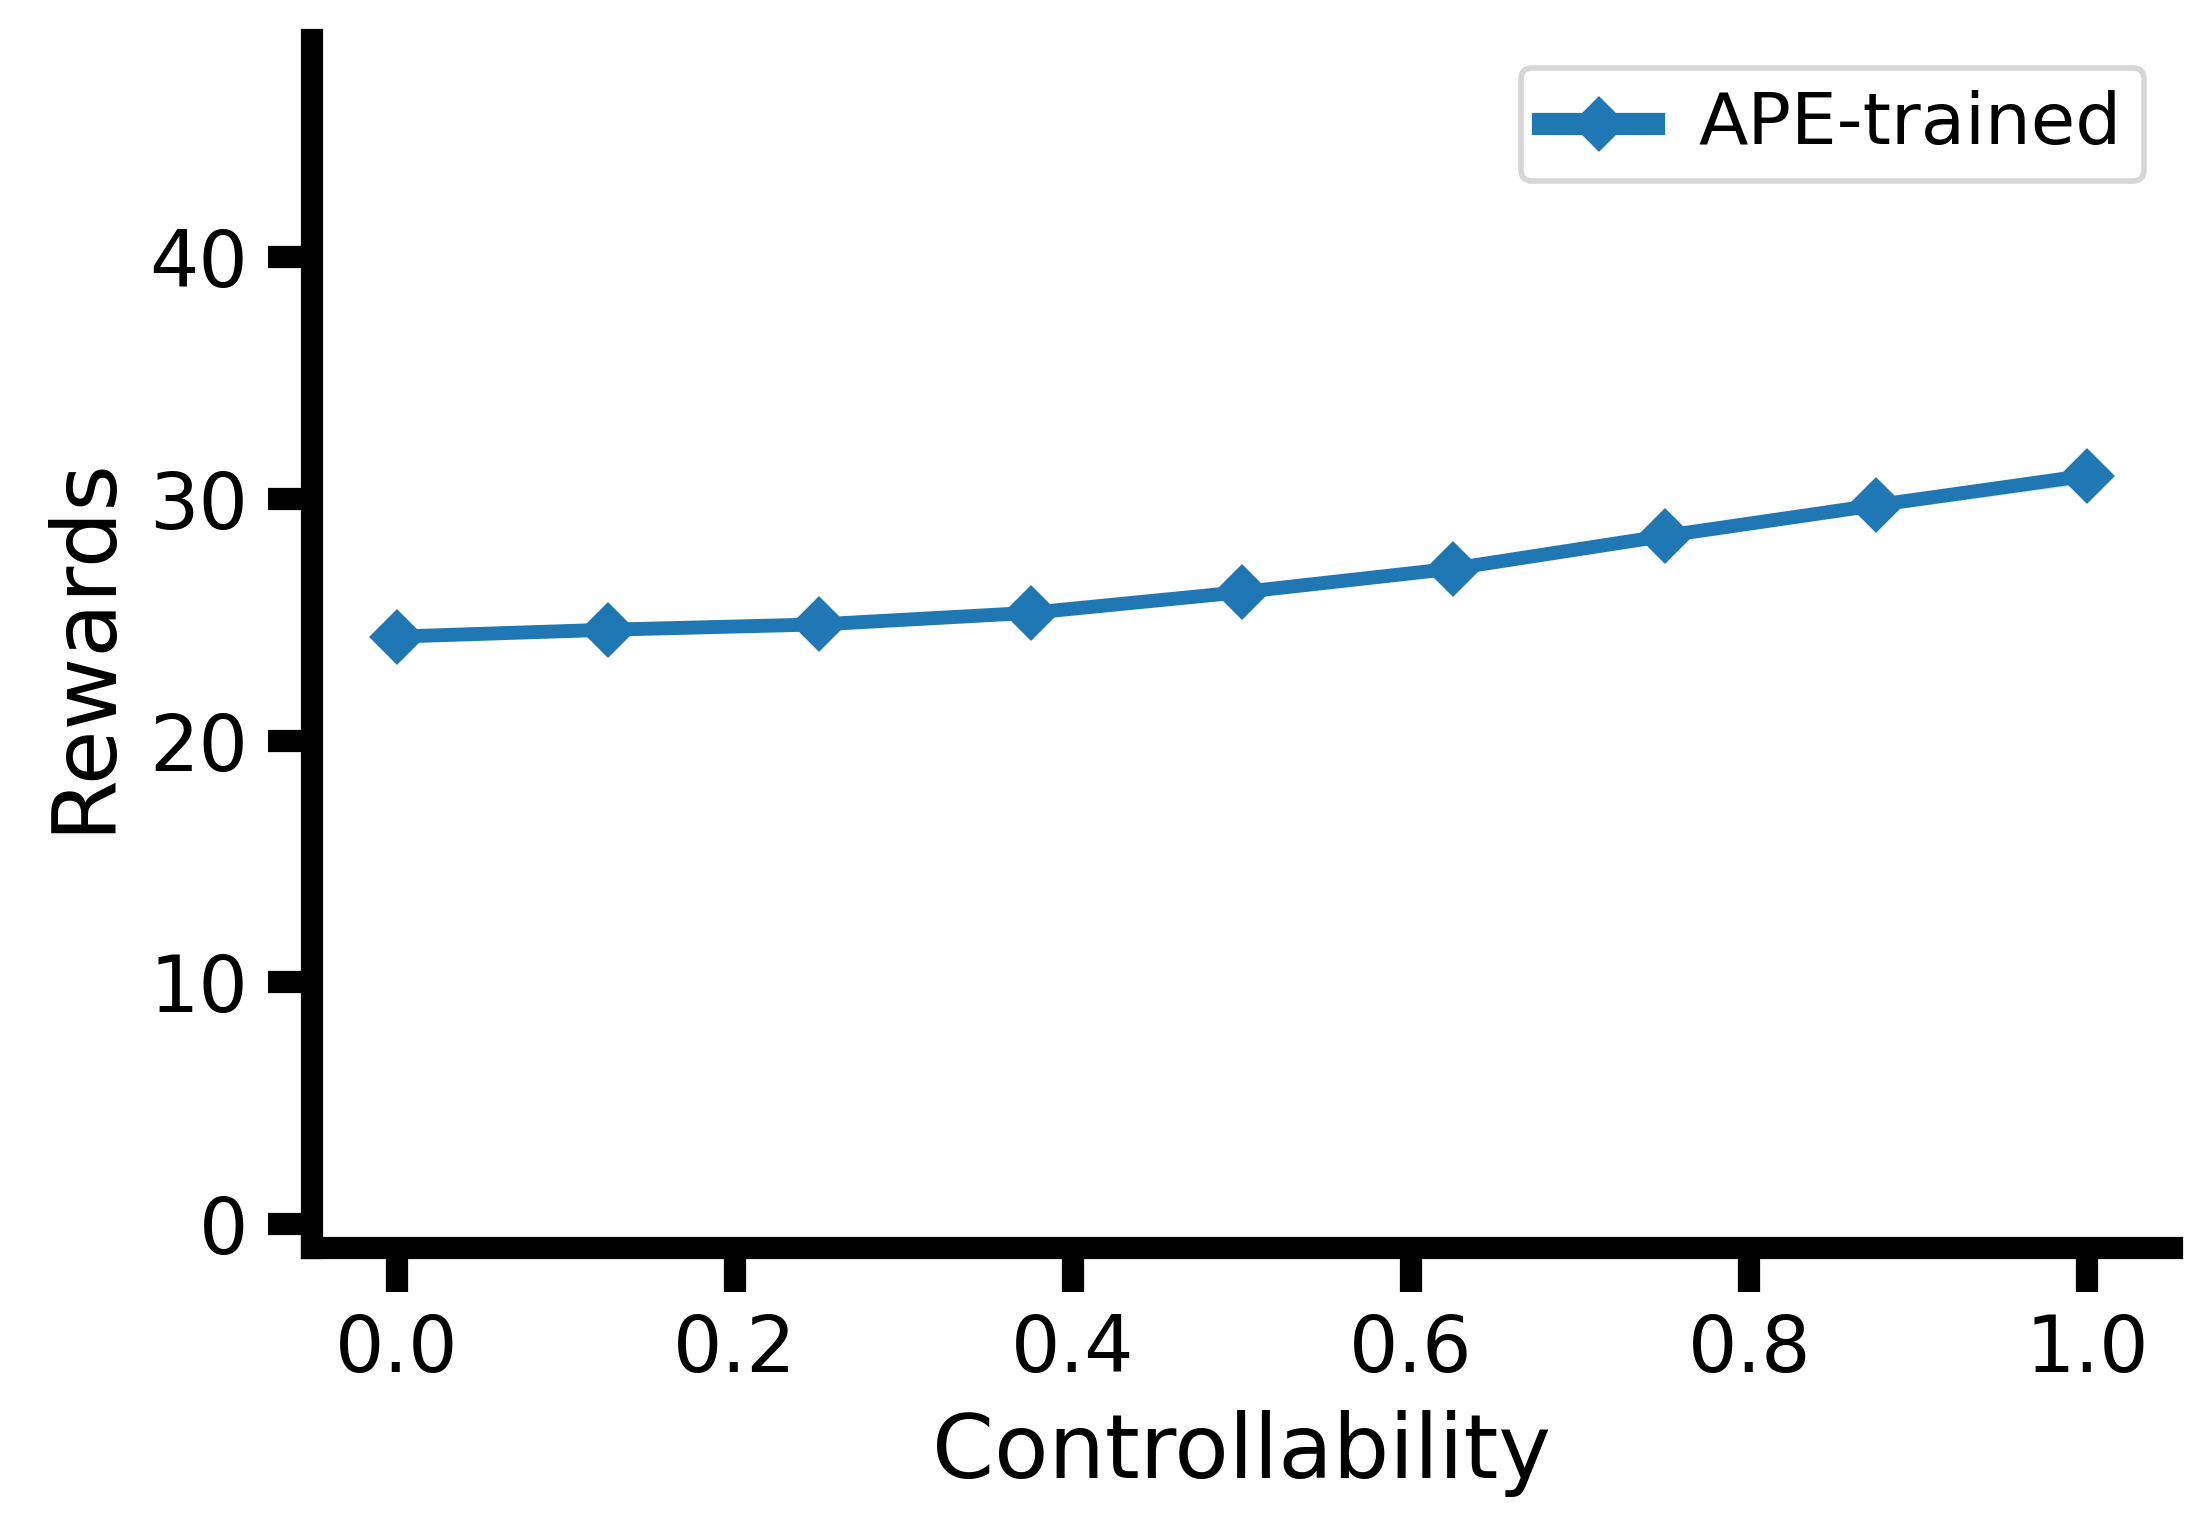

In [ ]:
fig = plot_comparison_curves_several_runs(test_taus, list(reversed(rewss_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_exp='APE-trained', ylim=ylim, marker='D')

In [ ]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.svg'))

### No-APE Networks

In [ ]:
from settings_anal import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

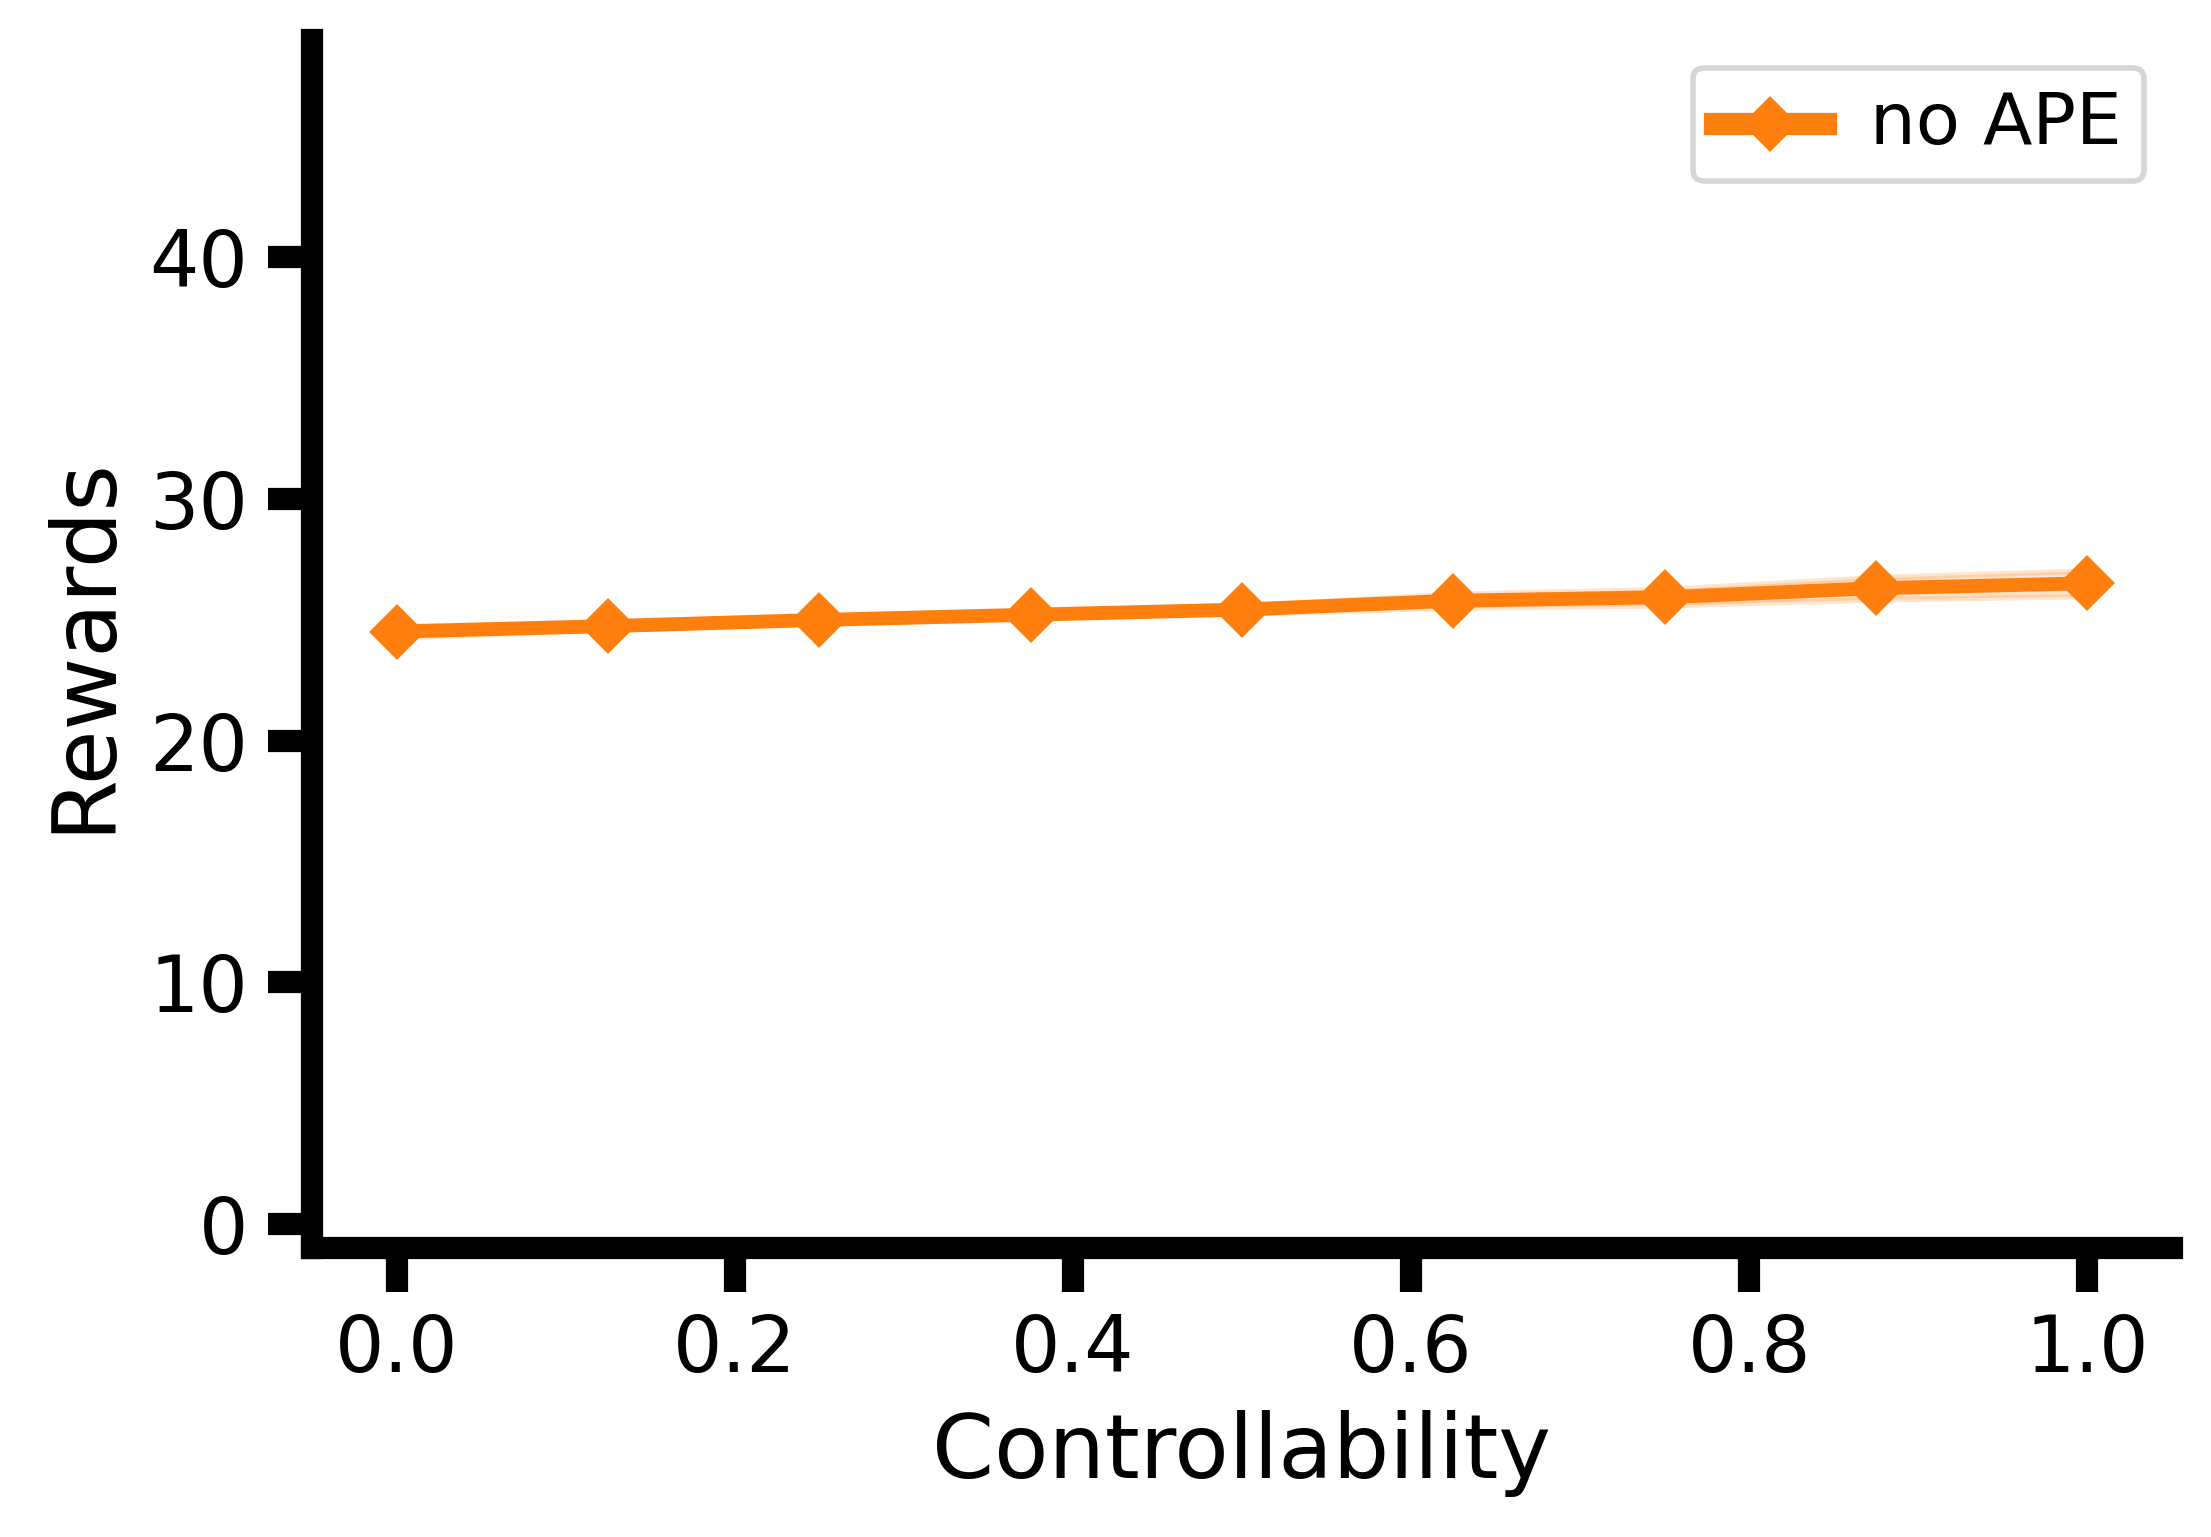

In [ ]:
fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(rewss_taus_control)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_control='no APE', ylim=ylim, marker='D')

In [ ]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.svg'))

## Stats
### Likelihood estimation

In [2]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

human_data_file_base = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis'

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [3]:
df_file_A_22 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527162302_behavior_diff_effs_24-01-22_day2_with_nets_groupA.pkl'
df_file_B_22 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527162823_behavior_diff_effs_24-01-22_day2B_with_nets_groupB.pkl'

df_file_A_29 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527164021_behavior_diff_effs_24-01-29_day2_with_nets_groupA.pkl'
df_file_B_29 = '/home/kai/Documents/Projects/HumanObserveBetEfficacyAnalysis/results/behavior/20240527164530_behavior_diff_effs_24-01-29_day2B_with_nets_groupB.pkl'

df_A = pd.read_pickle(df_file_A_22)
df_B = pd.read_pickle(df_file_B_22)

df_A_29 = pd.read_pickle(df_file_A_29)
df_B_29 = pd.read_pickle(df_file_B_29)

df_A = pd.concat([df_A, df_A_29])
df_B = pd.concat([df_B, df_B_29])

## only keep the rows in df_A that match an index in df (keeping in mind there might be missing keys)
df_A = df_A[df_A.index.isin(df.index)]
df_B = df_B[df_B.index.isin(df.index)]

In [4]:
from settings_anal import pepe_human_ape_models as ape_models
from settings_anal import pepe_human_control_models as control_models
from human_utils_project import sort_train_test


test_liks_A_ape = []
test_liks_A_noape = []
test_liks_B_ape = []
test_liks_B_noape = []

for model in ape_models:
    train_liks_A, test_liks_A = sort_train_test(df_A['step_l_%d' %model], df_A['effs'], test_start=5)
    test_liks_A_ape.append(test_liks_A)

for model in control_models:
    train_liks_A, test_liks_A = sort_train_test(df_A['step_l_%d' %model], df_A['effs'], test_start=5)
    test_liks_A_noape.append(test_liks_A)

for model in ape_models:
    train_liks_B, test_liks_B = sort_train_test(df_B['step_l_%d' %model], df_B['effs'], test_start=4)
    test_liks_B_ape.append(test_liks_B)

for model in control_models:
    train_liks_B, test_liks_B = sort_train_test(df_B['step_l_%d' %model], df_B['effs'], test_start=4)
    test_liks_B_noape.append(test_liks_B)

test_liks_A_ape = np.array(test_liks_A_ape)
test_liks_A_noape = np.array(test_liks_A_noape)
test_liks_B_ape = np.array(test_liks_B_ape)
test_liks_B_noape = np.array(test_liks_B_noape)

test_log_liks_A_ape = np.log(test_liks_A_ape).sum(axis=(2,3)).mean(axis=0)
test_log_liks_A_noape = np.log(test_liks_A_noape).sum(axis=(2,3)).mean(axis=0)
test_log_liks_B_ape = np.log(test_liks_B_ape).sum(axis=(2,3)).mean(axis=0)
test_log_liks_B_noape = np.log(test_liks_B_noape).sum(axis=(2,3)).mean(axis=0)

test_log_liks_ape = np.concatenate([test_log_liks_A_ape, test_log_liks_B_ape])
test_log_liks_noape = np.concatenate([test_log_liks_A_noape, test_log_liks_B_noape])

# test_liks_ape = [test_liks_A_ape[:,:,-1].mean(axis=(0,-1)), test_liks_B_ape[:,:,2].mean(axis=(0,-1)), test_liks_A_ape[:,:,0].mean(axis=(0,-1))]
# test_liks_noape = [test_liks_A_noape[:,:,-1].mean(axis=(0,-1)), test_liks_B_noape[:,:,2].mean(axis=(0,-1)), test_liks_A_noape[:,:,0].mean(axis=(0,-1))]
# plotted_levels = [1, 0.5, 0]


In [16]:
test_log_liks_ape

array([ -363.28003,  -607.51385,  -241.255  ,  -576.93225,  -453.8461 ,
        -804.7565 ,  -385.7108 ,  -182.80573,  -758.4735 ,  -750.74695,
        -201.57501,  -618.94006,  -574.3519 ,  -638.19324,  -554.9235 ,
        -716.6028 ,  -976.5804 ,  -235.1971 ,  -353.23267,  -187.86916,
        -311.7671 ,  -580.4729 ,  -282.10562,  -208.50418,  -297.87756,
        -309.13483,  -216.8081 ,  -254.10506,  -500.02383,  -535.4814 ,
        -192.32184,  -260.59918,  -452.52158,  -246.2952 ,  -320.43243,
        -296.84903,  -771.46063,  -323.11627,  -234.5413 ,  -494.2418 ,
        -314.53595,  -227.60286,  -612.5376 ,  -285.7924 ,  -247.99092,
        -587.6279 ,  -914.4038 ,  -330.02673,  -965.02325,  -231.38913,
        -774.7299 ,  -264.68396,  -681.96436,  -637.4237 ,  -422.69614,
        -448.85825,  -389.39325,  -331.95258,  -363.09833, -1091.1127 ,
        -578.2069 ,  -842.6576 ,  -536.635  ,  -713.7173 ,  -416.23984,
        -799.1179 ,  -305.7055 ,  -256.49286,  -328.69858,  -737

In [15]:
from groupBMC import GroupBMC

L = np.array([test_log_liks_ape, test_log_liks_noape])
result = GroupBMC(L).get_result()

print("Model frequencies", result.frequency_mean)
print("Model frequencies variance", result.frequency_var)
print("Model frequences std", np.sqrt(result.frequency_var))
print("Model SEM", np.sqrt(result.frequency_var)/ np.sqrt(len(test_log_liks_ape)))
print("N=", len(test_log_liks_ape))
print("Exceedance probabilities", result.exceedance_probability)

Model frequencies [0.99553571 0.00446429]
Model frequencies variance [3.93305829e-05 3.93305829e-05]
Model frequences std [0.00627141 0.00627141]
Model SEM [0.00059526 0.00059526]
N= 111
Exceedance probabilities [1.00000000e+00 2.16065456e-37]


In [25]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests


## MEANS AND SEMS
print("Overall N", len(df))

p_values = []

for level, liks, liks_noape in zip(plotted_levels, test_liks_ape, test_liks_noape):
    ## AVERAGE STATS
    print("Test Controllability ", level)
    print("Mean APE", liks.mean())
    print("StdErr APE", liks.std()/np.sqrt(liks.shape[0]))
    print("N APE", liks.shape[0])
    
    print("Mean NOAPE", liks_noape.mean())
    print("StdErr NOAPE", liks_noape.std()/np.sqrt(liks_noape.shape[0]))
    print("N NOAPE", liks_noape.shape[0])

    ## paired t-test
    ttest = ttest_rel(liks, liks_noape, alternative='greater')
    print(ttest)
    p_values.append(ttest.pvalue)

## MULTIPLE COMPARISONS
rejects, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')
print(rejects)
print(p_values_corrected)

Overall N 111
Test Controllability  1
Mean APE 0.64828455
StdErr APE 0.032885752642098774
N APE 46
Mean NOAPE 0.5193321
StdErr NOAPE 0.01781263220435191
N NOAPE 46
TtestResult(statistic=4.382374171570158, pvalue=3.478475123286644e-05, df=45)
Test Controllability  0.5
Mean APE 0.6098049
StdErr APE 0.023917397474663916
N APE 65
Mean NOAPE 0.4813526
StdErr NOAPE 0.013706170910942134
N NOAPE 65
TtestResult(statistic=5.2869110429825845, pvalue=8.028168688747074e-07, df=64)
Test Controllability  0
Mean APE 0.5624307
StdErr APE 0.0219809138864937
N APE 46
Mean NOAPE 0.5342141
StdErr NOAPE 0.02146576568873027
N NOAPE 46
TtestResult(statistic=1.0590984795602612, pvalue=0.1476034607207268, df=45)
[ True  True False]
[6.95695025e-05 2.40845061e-06 1.47603461e-01]


In [26]:
import pandas as pd

# Initialize a list to store the results
results = []

for level, liks, liks_noape in zip(plotted_levels, test_liks_ape, test_liks_noape):
    # Calculate statistics
    mean_ape = liks.mean()
    stderr_ape = liks.std()/np.sqrt(liks.shape[0])
    n_ape = liks.shape[0]
    
    mean_noape = liks_noape.mean()
    stderr_noape = liks_noape.std()/np.sqrt(liks_noape.shape[0])
    n_noape = liks_noape.shape[0]

    # Perform t-test
    ttest = ttest_rel(liks, liks_noape, alternative='greater')

    # Calculate degrees of freedom
    df = len(liks) - 1

    # Append results to the list
    results.append([level, n_ape, mean_ape, stderr_ape, mean_noape, stderr_noape, df, ttest.pvalue, ])

# Convert the list to a DataFrame
df_results = pd.DataFrame(results, columns=['Controllability', 'N', 'Mean APE', 'StdErr APE', 'Mean Standard', 'StdErr Standard', 'df', 'p-value',])

# Perform multiple comparisons correction
rejects, p_values_corrected, _, _ = multipletests(df_results['p-value'], alpha=0.05, method='holm')

# Add the corrected p-values and rejection decisions to the DataFrame
df_results['p-value corrected'] = p_values_corrected
df_results['reject'] = rejects

# Set "Controllability" to index column
#df_results.set_index('Controllability', inplace=True, drop=True)
df_results.rename_axis('Index', inplace=True)

df_results = df_results.round(3)

# Print the DataFrame
df_results

,Controllability,N,Mean APE,StdErr APE,Mean Standard,StdErr Standard,df,p-value,p-value corrected,reject
Index,,,,,,,,,,
0,1.0,46,0.648,0.033,0.519,0.018,45,0.000,0.000,True
1,0.5,65,0.610,0.024,0.481,0.014,64,0.000,0.000,True
2,0.0,46,0.562,0.022,0.534,0.021,45,0.148,0.148,False


In [39]:
import pandas as pd

# Initialize a list to store the results
results = []

#for level, liks, liks_noape in zip(effs, test_liks_ape, test_liks_noape):
for eff in np.arange(0, 1.01, 0.125):
    print(eff, effs_test[0], effs_test[1])
    if eff in effs_test[0]:
        print(effs_test[0].index(eff))
    else:
        print(effs_test[1].index(eff))
    liks = test_liks_A_ape[:, :, effs_test[0].index(eff)] if eff in effs_test[0] else test_liks_B_ape[:, :, effs_test[1].index(eff)]
    liks = liks.mean(axis=(0,-1))
    liks_noape = test_liks_A_noape[:, :, effs_test[0].index(eff)] if eff in effs_test[0] else test_liks_B_noape[:, :, effs_test[1].index(eff)]
    liks_noape = liks_noape.mean(axis=(0,-1))

    # Calculate statistics
    mean_ape = liks.mean()
    stderr_ape = liks.std()/np.sqrt(liks.shape[0])
    n_ape = liks.shape[0]
    
    mean_noape = liks_noape.mean()
    stderr_noape = liks_noape.std()/np.sqrt(liks_noape.shape[0])
    n_noape = liks_noape.shape[0]

    # Perform t-test
    ttest = ttest_rel(liks, liks_noape, alternative='greater')
    print(ttest)

    # Calculate degrees of freedom
    df = len(liks) - 1

    # Append results to the list
    results.append([level, n_ape, mean_ape, stderr_ape, mean_noape, stderr_noape, df, ttest[0], ttest.pvalue, ])

# Convert the list to a DataFrame
df_results = pd.DataFrame(results, columns=['Controllability', 'N', 'Mean APE', 'StdErr APE', 'Mean Standard', 'StdErr Standard', 'df', 't-stat', 'p-value',])

# Perform multiple comparisons correction
rejects, p_values_corrected, _, _ = multipletests(df_results['p-value'], alpha=0.05, method='holm')

# Add the corrected p-values and rejection decisions to the DataFrame
df_results['p-value corrected'] = p_values_corrected
df_results['reject'] = rejects

# Set "Controllability" to index column
#df_results.set_index('Controllability', inplace=True, drop=True)
df_results.rename_axis('Index', inplace=True)

df_results = df_results.round(3)

# Print the DataFrame
df_results

0.0 [0, 0.25, 0.75, 1.0] [0.125, 0.375, 0.5, 0.625, 0.875]
0
TtestResult(statistic=1.0590984795602612, pvalue=0.1476034607207268, df=45)
0.125 [0, 0.25, 0.75, 1.0] [0.125, 0.375, 0.5, 0.625, 0.875]
0
TtestResult(statistic=4.970849309827105, pvalue=2.6348240429590767e-06, df=64)
0.25 [0, 0.25, 0.75, 1.0] [0.125, 0.375, 0.5, 0.625, 0.875]
1
TtestResult(statistic=5.007846162060969, pvalue=4.480918858467041e-06, df=45)
0.375 [0, 0.25, 0.75, 1.0] [0.125, 0.375, 0.5, 0.625, 0.875]
1
TtestResult(statistic=5.861651237543418, pvalue=8.723881005775804e-08, df=64)
0.5 [0, 0.25, 0.75, 1.0] [0.125, 0.375, 0.5, 0.625, 0.875]
2
TtestResult(statistic=5.2869110429825845, pvalue=8.028168688747074e-07, df=64)
0.625 [0, 0.25, 0.75, 1.0] [0.125, 0.375, 0.5, 0.625, 0.875]
3
TtestResult(statistic=5.037902736140775, pvalue=2.052148936299469e-06, df=64)
0.75 [0, 0.25, 0.75, 1.0] [0.125, 0.375, 0.5, 0.625, 0.875]
2
TtestResult(statistic=5.218004463378611, pvalue=2.2184022254776446e-06, df=45)
0.875 [0, 0.25, 0.

,Controllability,N,Mean APE,StdErr APE,Mean Standard,StdErr Standard,df,t-stat,p-value,p-value corrected,reject
Index,,,,,,,,,,,
0,0,46,0.562,0.022,0.534,0.021,45,1.059,0.148,0.148,False
1,0,65,0.591,0.017,0.493,0.015,64,4.971,0.000,0.000,True
2,0,46,0.654,0.021,0.527,0.019,45,5.008,0.000,0.000,True
3,0,65,0.613,0.021,0.480,0.012,64,5.862,0.000,0.000,True
4,0,65,0.610,0.024,0.481,0.014,64,5.287,0.000,0.000,True
5,0,65,0.611,0.027,0.485,0.013,64,5.038,0.000,0.000,True
6,0,46,0.660,0.029,0.488,0.014,45,5.218,0.000,0.000,True
7,0,65,0.592,0.031,0.488,0.012,64,3.310,0.001,0.002,True
8,0,46,0.648,0.033,0.519,0.018,45,4.382,0.000,0.000,True


In [37]:
#test_liks_A_ape.shape
test_liks_B_ape.shape

(10, 65, 5, 50)

In [31]:
df_results['p-value']

0    [[0.21268047276849933, 0.09889201639633535, 0....
1    [[0.21268047276849933, 0.9686015378958075, 0.6...
2    [[0.21268047276849933, 0.16316568433457407, 0....
3    [[0.21268047276849933, 0.9209015922552268, 0.1...
4    [[0.21268047276849933, 0.9209015922552268, 0.9...
5    [[0.21268047276849933, 0.9686015378958075, 0.6...
6    [[0.21268047276849933, 0.09889201639633535, 0....
7    [[0.21268047276849933, 0.9686015378958075, 0.0...
8    [[0.21268047276849933, 0.16316568433457407, 0....
Name: p-value, dtype: object